In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Collect Data

In [109]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

oil_tickers_names = {'CL=F':'Crude Oil',
                     'NG=F':'Natural Gas'}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
for symbol, name in oil_tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('data/stock_data.csv', index = False)


# Inspect Data

## General

In [110]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6483 entries, 0 to 6482
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   6483 non-null   object        
 1   company  6483 non-null   object        
 2   date     6483 non-null   datetime64[ns]
 3   open     6483 non-null   float64       
 4   high     6483 non-null   float64       
 5   low      6483 non-null   float64       
 6   close    6483 non-null   float64       
 7   volume   6483 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 405.3+ KB
None


In [111]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           6483  6483.000000  6483.000000  6483.000000   
mean   2023-02-25 03:13:27.959278336    64.344922    65.085900    63.577709   
min              2021-01-04 00:00:00     1.533000     1.628000     1.481000   
25%              2022-01-28 00:00:00    30.188483    30.499230    30.006168   
50%              2023-02-27 00:00:00    61.580002    62.212318    60.923481   
75%              2024-03-25 00:00:00    93.959431    95.419302    92.703188   
max              2025-04-22 00:00:00   169.405684   171.723312   168.554651   
std                              NaN    45.185071    45.656292    44.685012   

             close        volume  
count  6483.000000  6.483000e+03  
mean     64.338904  7.705255e+06  
min       1.575000  0.000000e+00  
25%      30.282249  3.318170e+05  
50%      61.549999  5.925100e+06  
75%      94.093315  1.133035e+07  
ma

In [112]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Natural Gas    1082
Crude Oil      1081
ExxonMobil     1080
Shell          1080
Chevron        1080
BP             1080
Name: count, dtype: int64


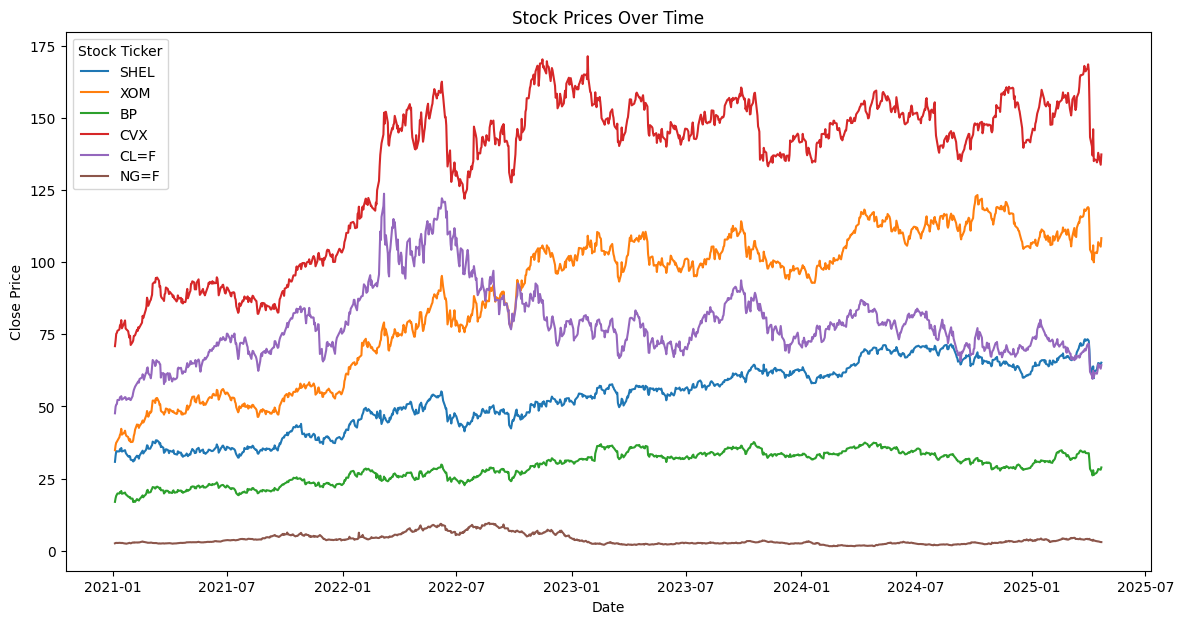

In [113]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.savefig("plots/stock_prices_over_time.png", dpi=300, bbox_inches='tight') 
plt.show()

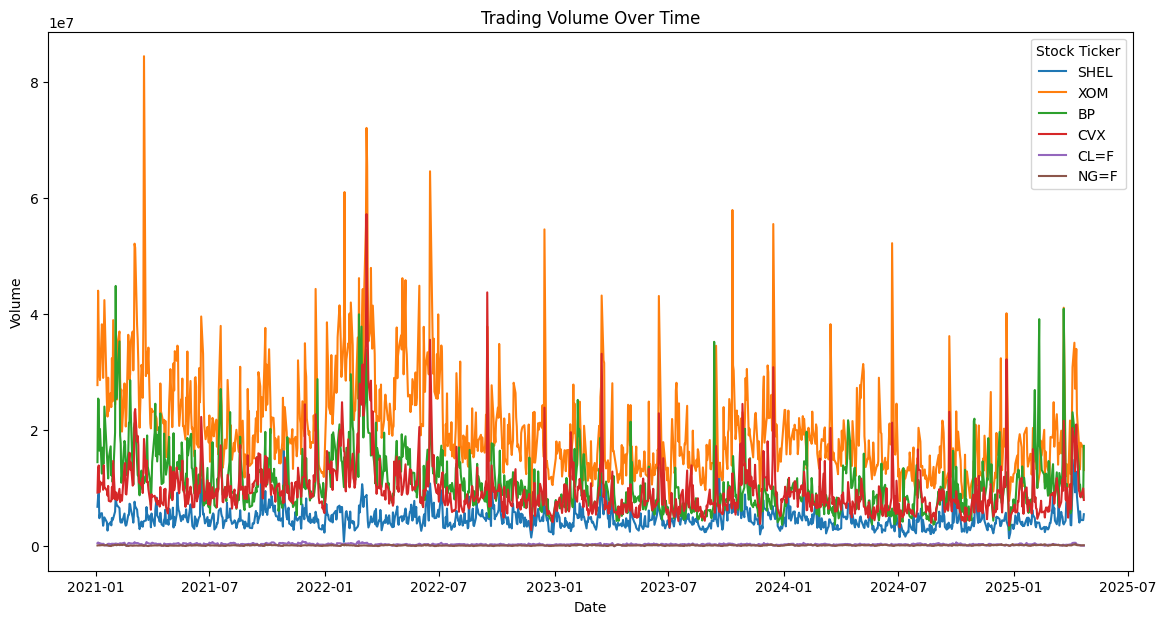

In [114]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.savefig("plots/trading_volume_over_time.png", dpi=300, bbox_inches='tight') 
plt.show()

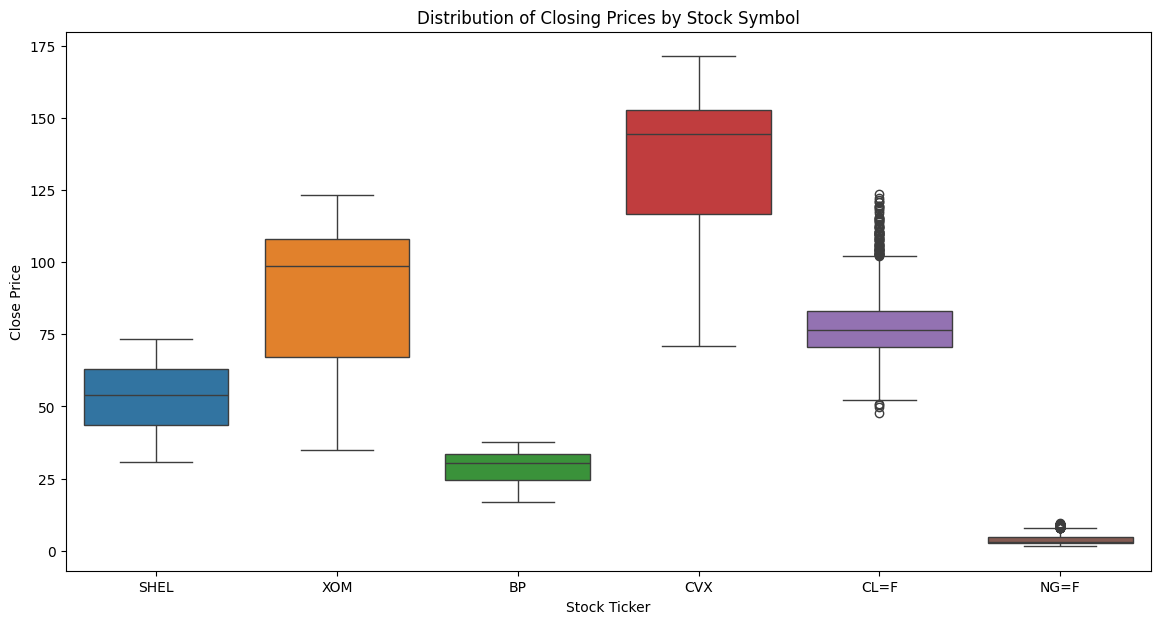

In [115]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.savefig("plots/distribution_of_closing_prices_by_stock_symbol.png", dpi=300, bbox_inches='tight') 
plt.show()

In [116]:
# pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
# pivot_table

pivot_table = stock_data.reset_index().pivot(index='date', columns='ticker', values='close')
pivot_table


ticker             BP       CL=F         CVX   NG=F       SHEL         XOM
date                                                                      
2021-01-04  16.946373  47.619999   70.881584  2.581  30.810040   34.851479
2021-01-05  18.207382  49.930000   72.797760  2.702  32.930744   36.531078
2021-01-06  19.045345  50.630001   75.140663  2.716  34.452866   37.463242
2021-01-07  19.452124  50.830002   75.492119  2.729  34.495605   37.757175
2021-01-08  19.850773  52.240002   76.211723  2.700  34.410095   38.177078
...               ...        ...         ...    ...        ...         ...
2025-04-15  27.209999  61.330002  134.539993  3.329  62.779999  103.099998
2025-04-16  27.660000  62.470001  135.360001  3.247  64.029999  104.190002
2025-04-17  28.320000  64.680000  137.869995  3.245  65.040001  106.919998
2025-04-21  28.080000  63.080002  133.729996  3.016  64.650002  105.349998
2025-04-22  28.870001  64.309998  137.300003  3.007  65.169998  108.300003

[1082 rows x 6 columns]

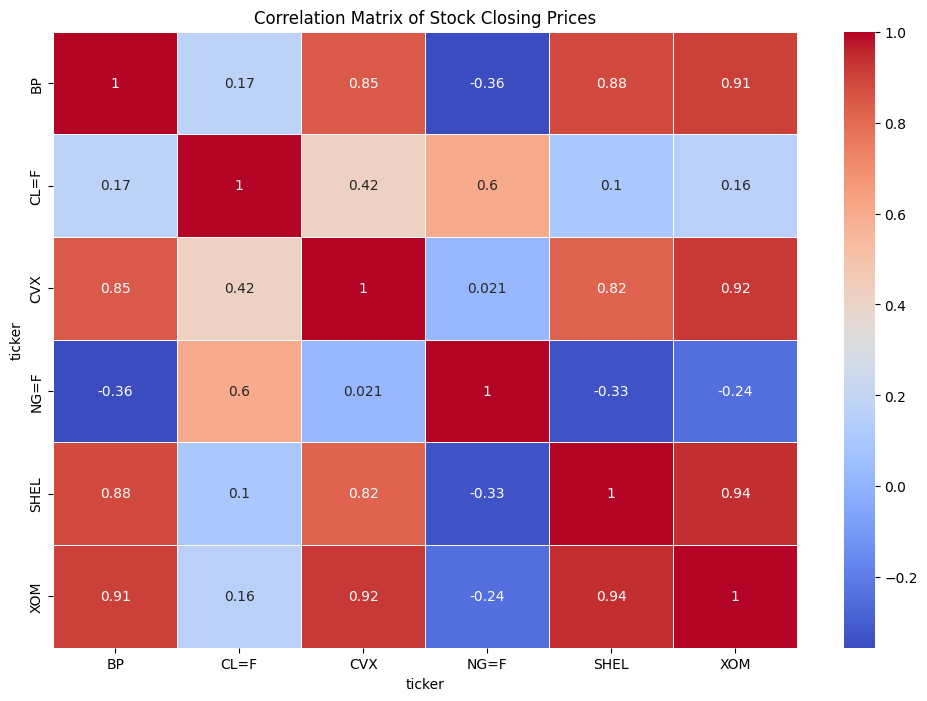

In [117]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.savefig("plots/correlation_matrix_of_stock_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

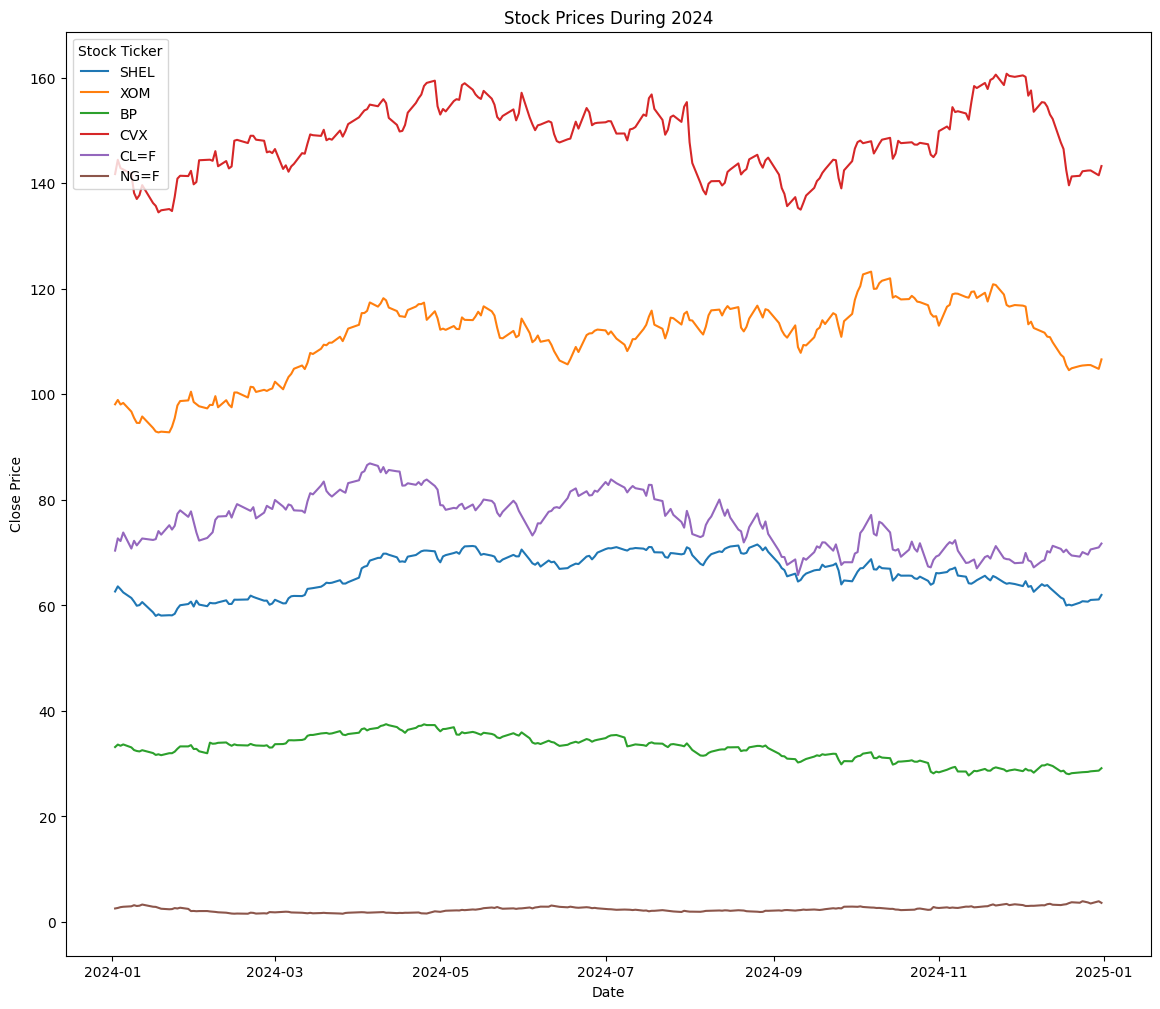

In [118]:
stock_data_2024 = stock_data.reset_index()[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/stock_prices_during_2024.png", dpi=300, bbox_inches='tight') 
plt.show()

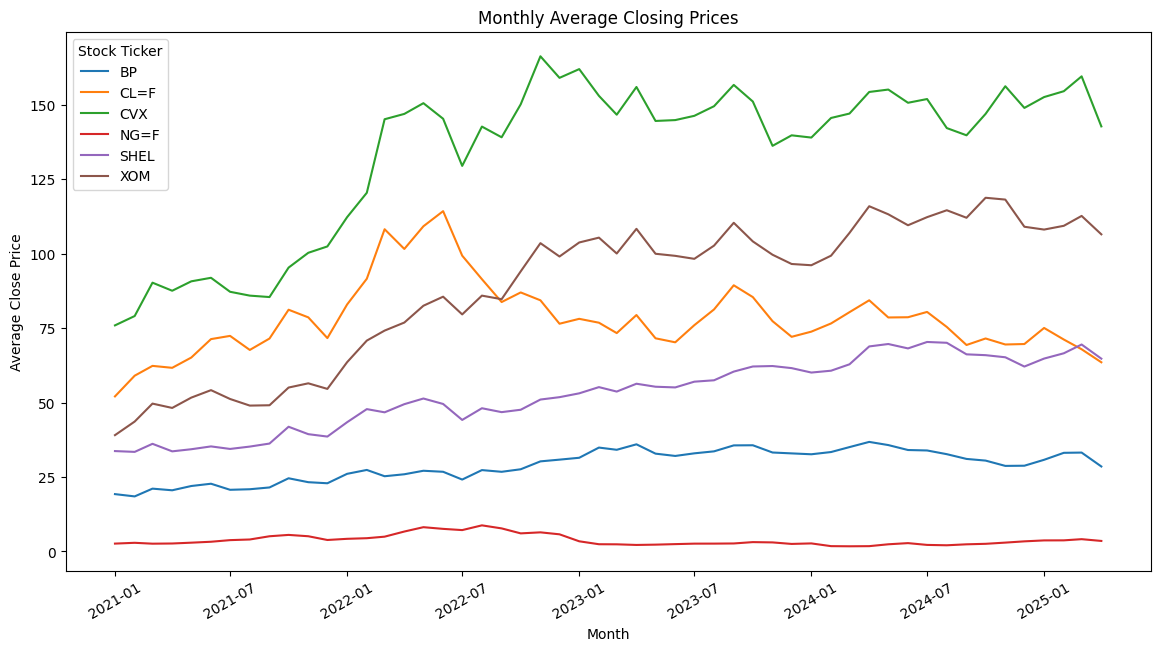

In [119]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/monthly_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

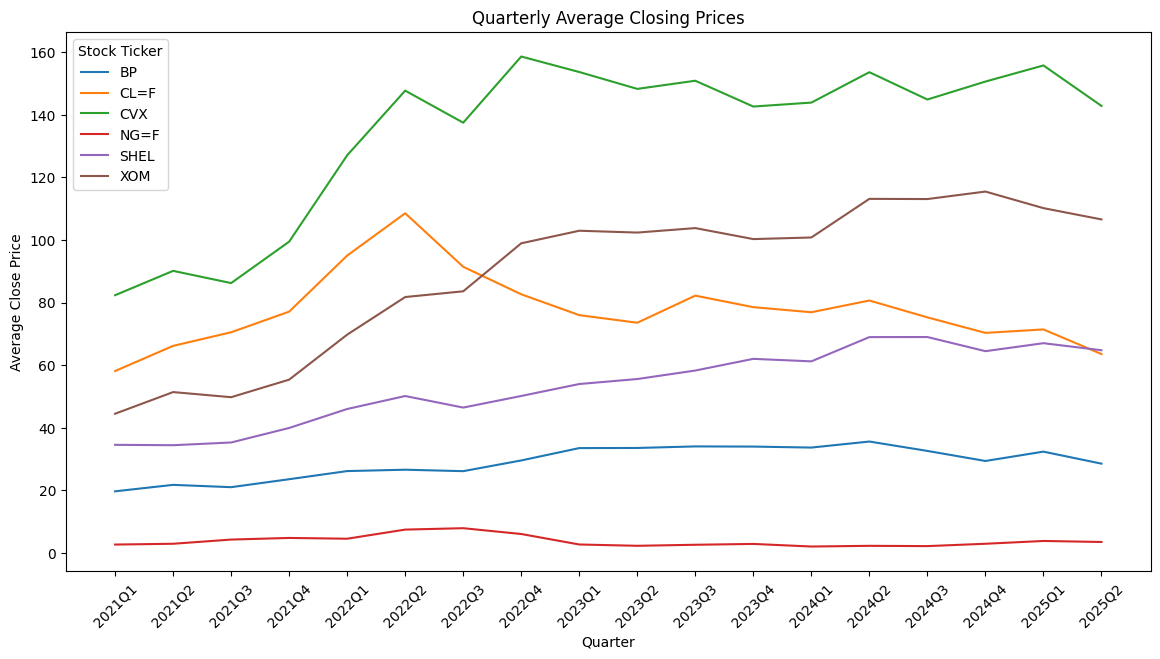

In [120]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/quarterly_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

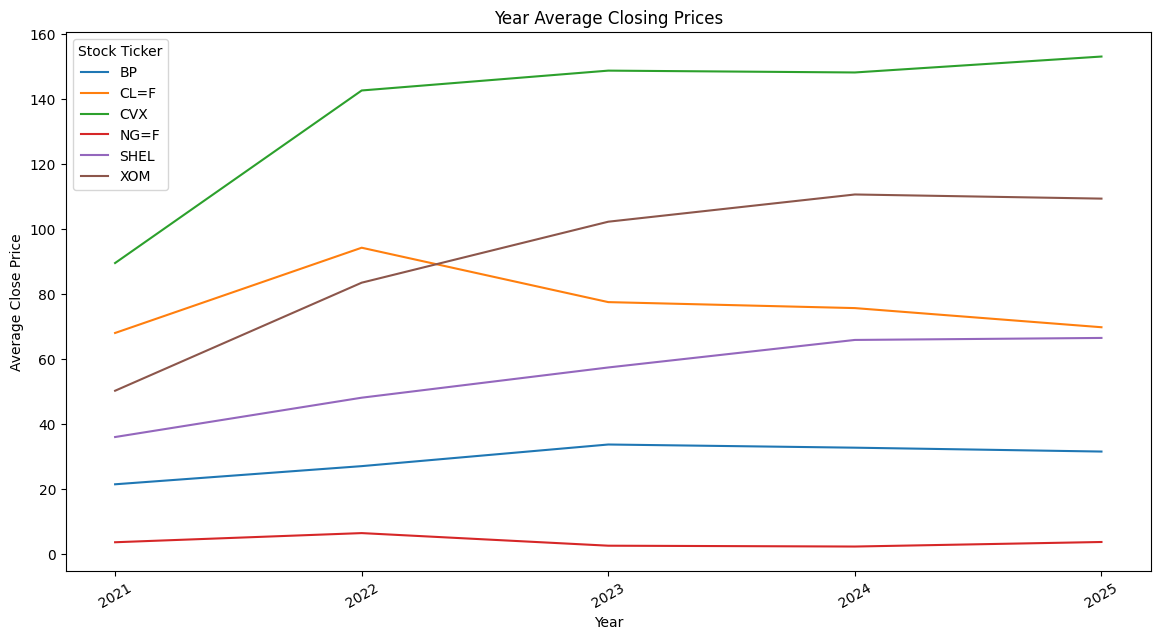

In [121]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/year_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

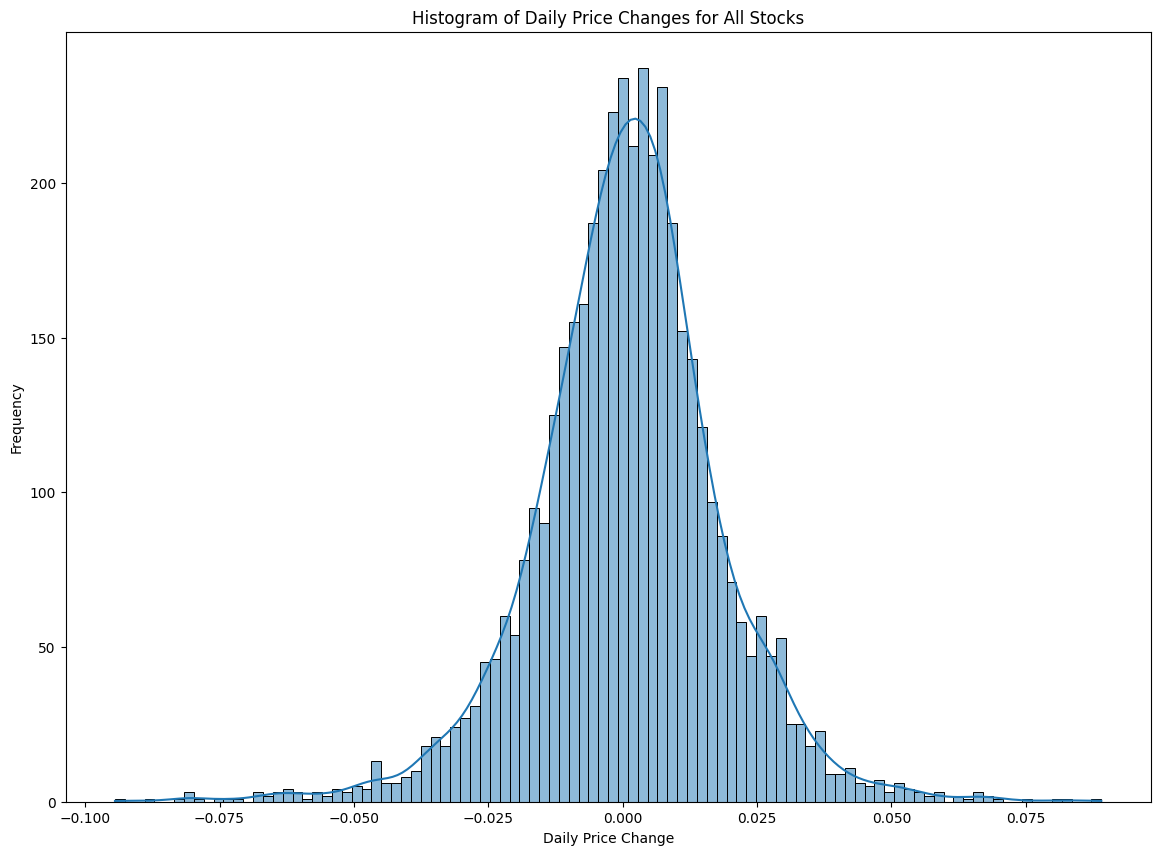

In [122]:
stock_data['price_change'] = stock_data[~stock_data['ticker'].isin(['CL=F','NG=F'])].groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_daily_price_changes_for_all_stocks.png", dpi=300, bbox_inches='tight') 
plt.show()

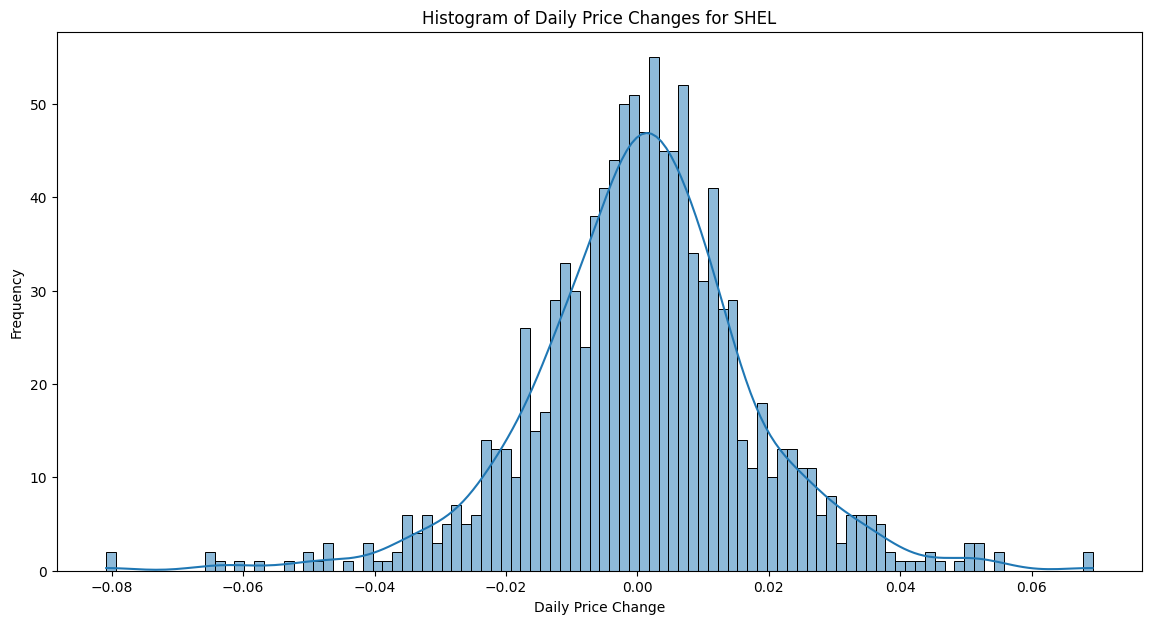

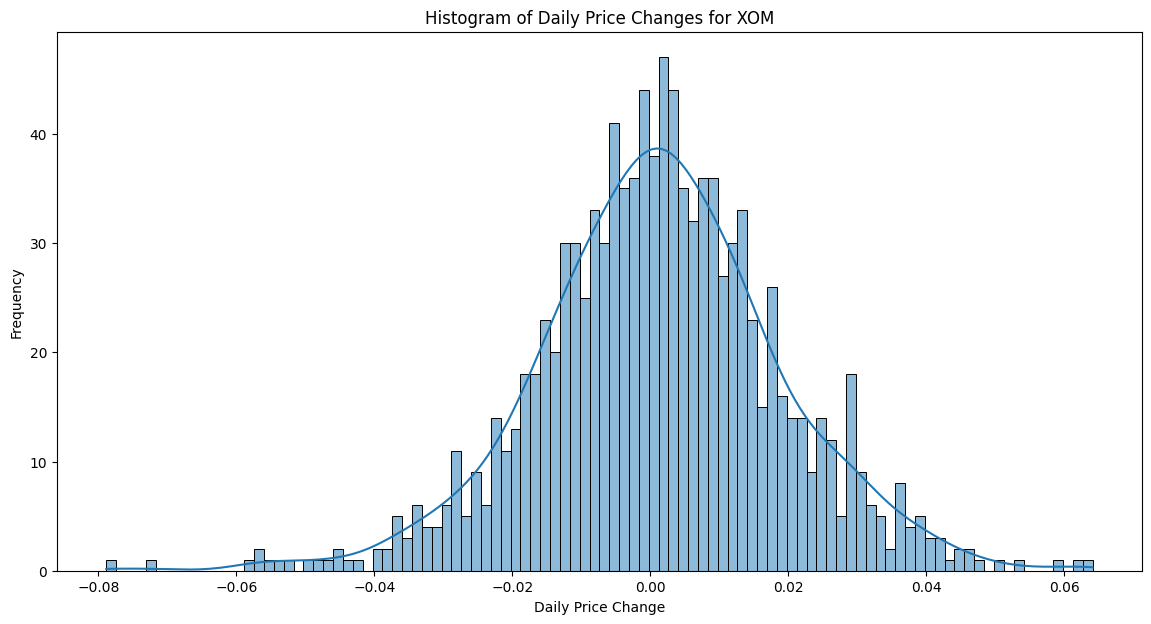

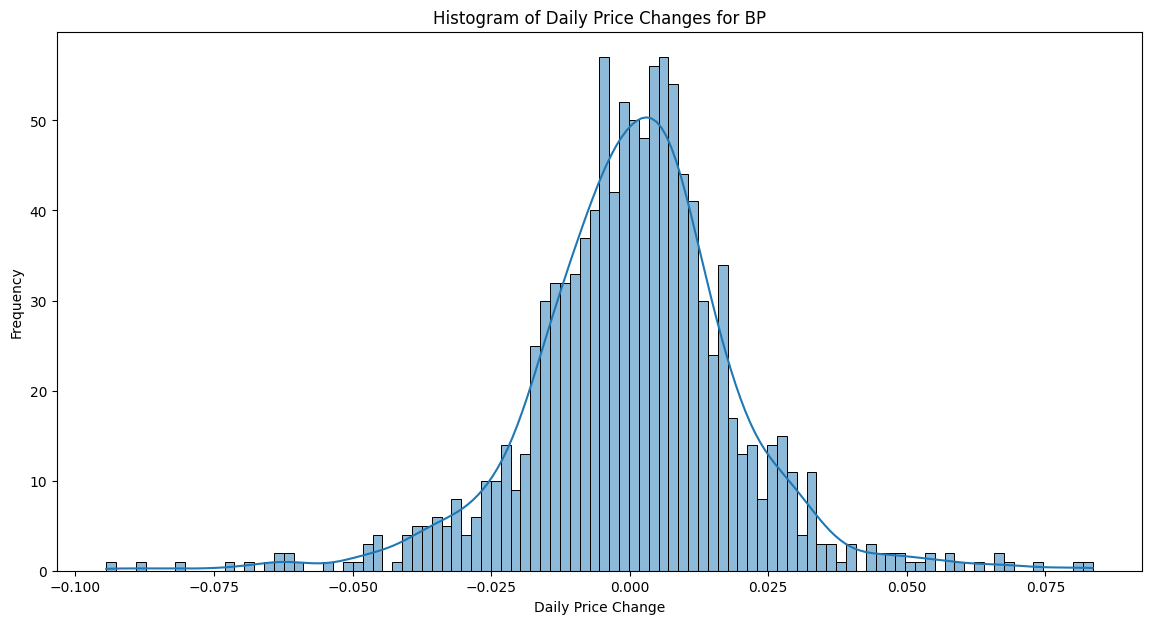

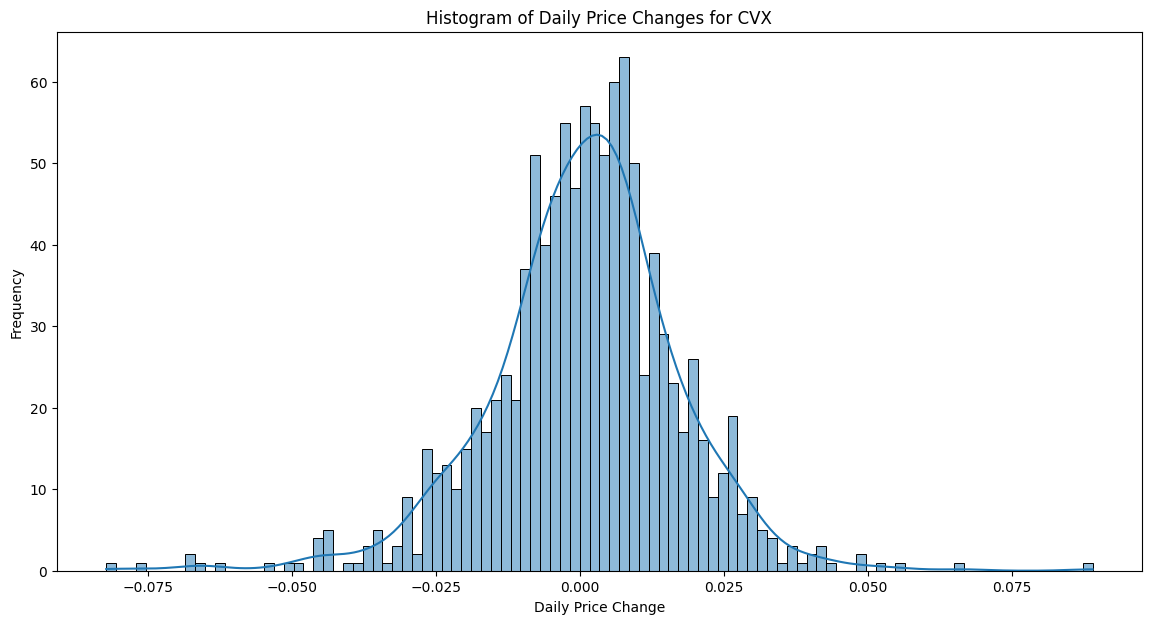

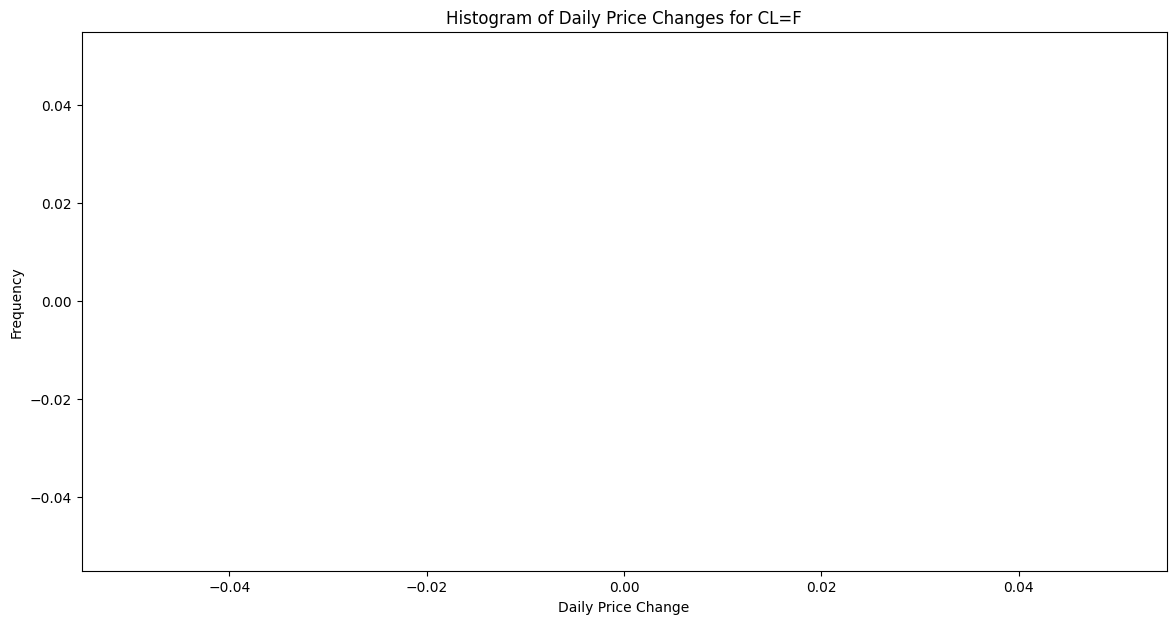

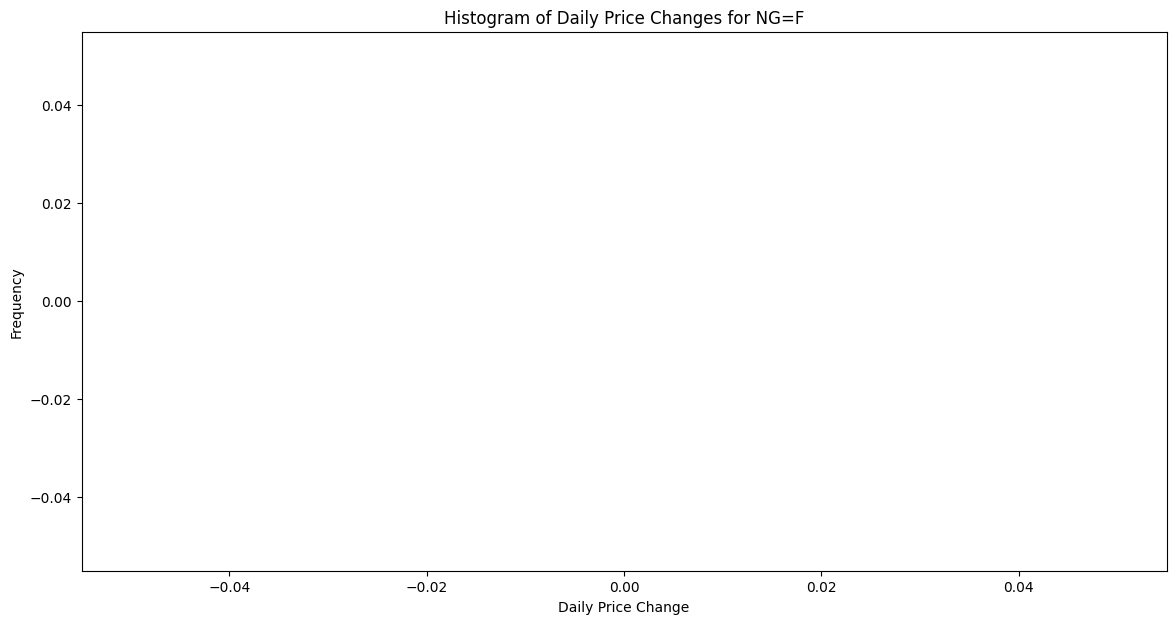

In [123]:
unique_tickers = stock_data['ticker'].unique()

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.savefig(f"plots/histogram_of_daily_price_changes_for_{t}.png", dpi=300, bbox_inches='tight') 
    plt.show()

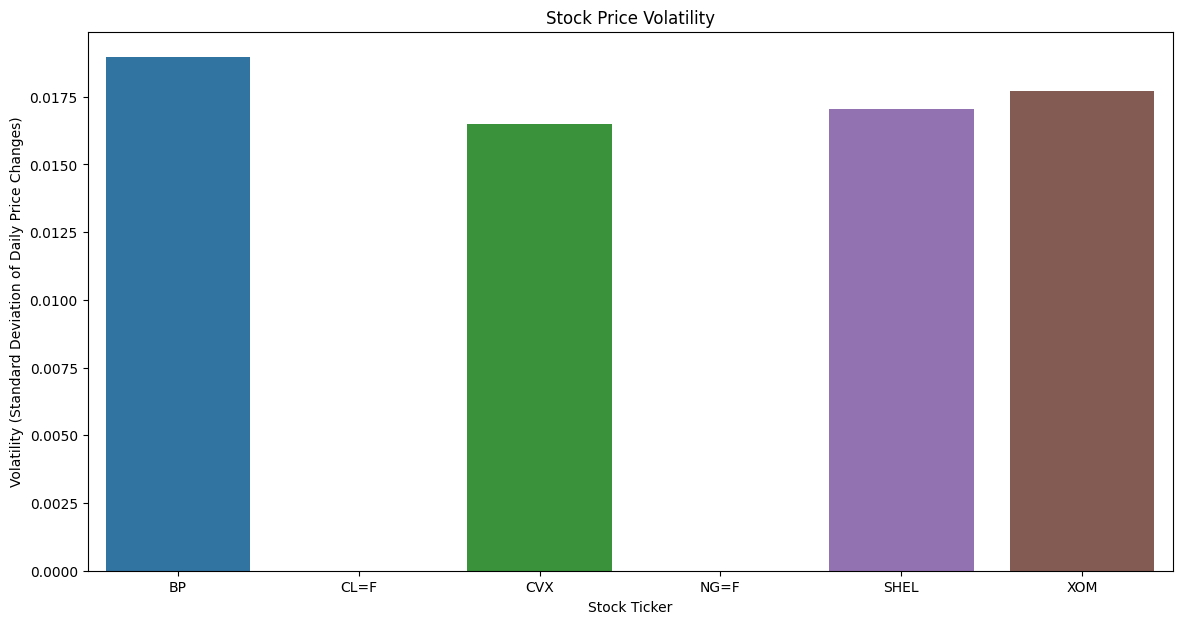

In [124]:
volatility = stock_data.groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.savefig("plots/stock_price_volatility.png", dpi=300, bbox_inches='tight') 
plt.show()

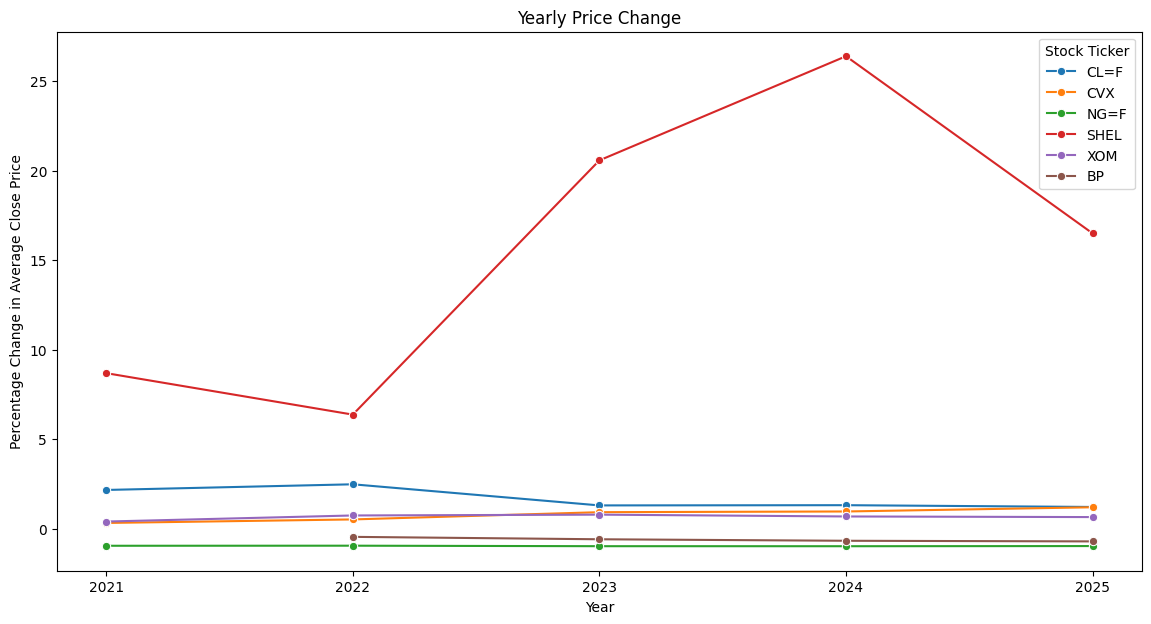

In [125]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.title('Yearly Price Change')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/yearly_price_change.png", dpi=300, bbox_inches='tight') 
plt.show()

## Shell

In [126]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

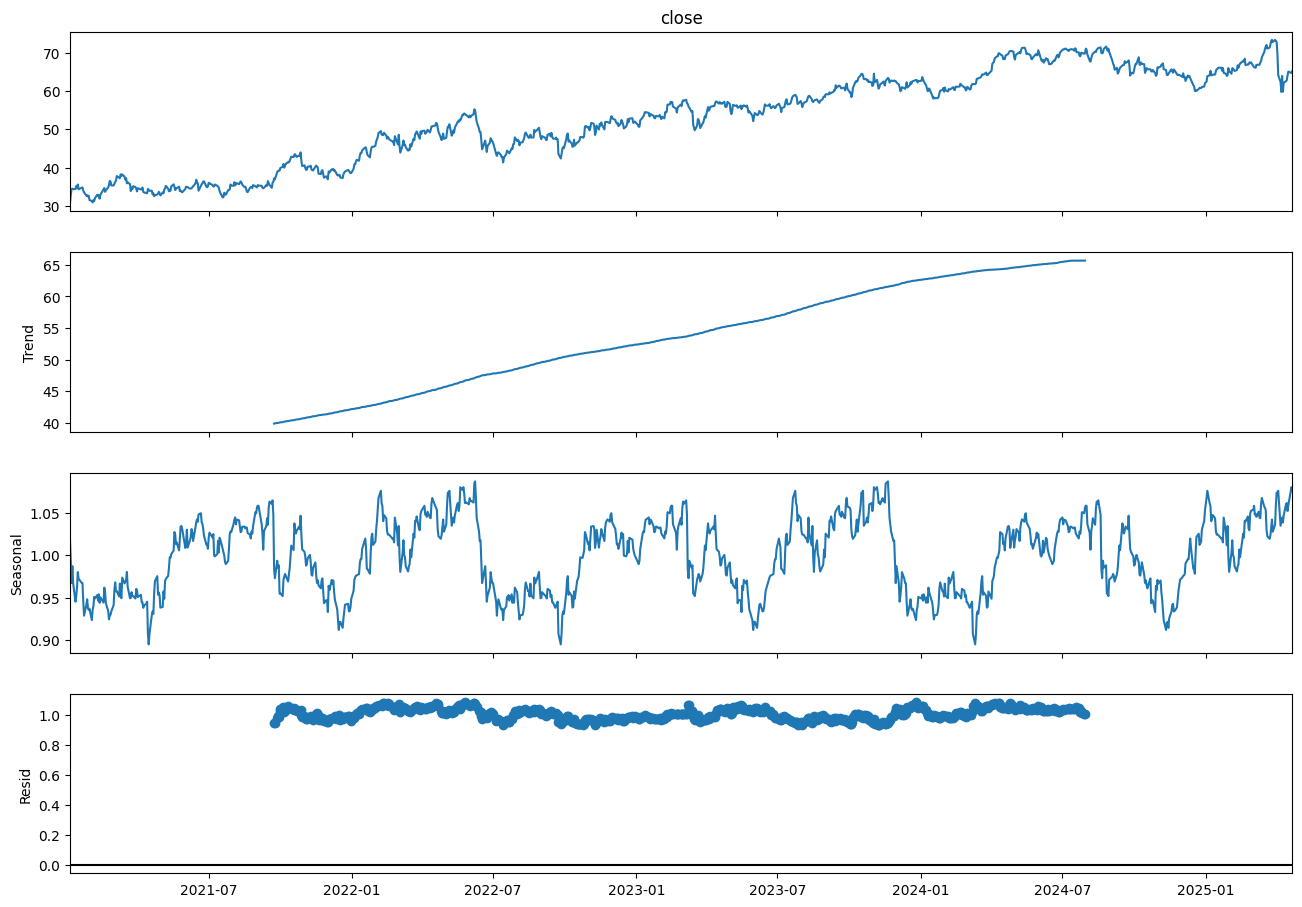

In [127]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

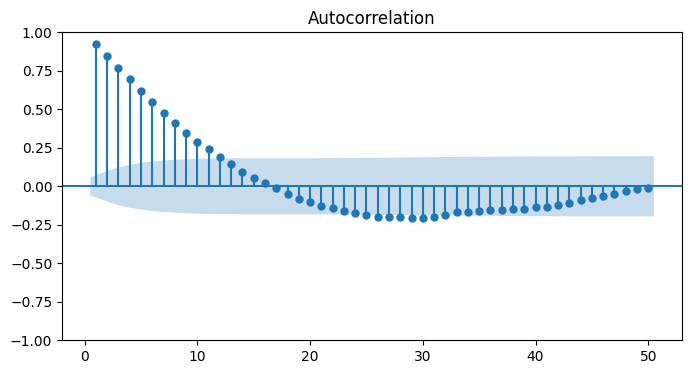

In [128]:
# Subtract long rolling average
detrend = shell_stock['close'] - shell_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

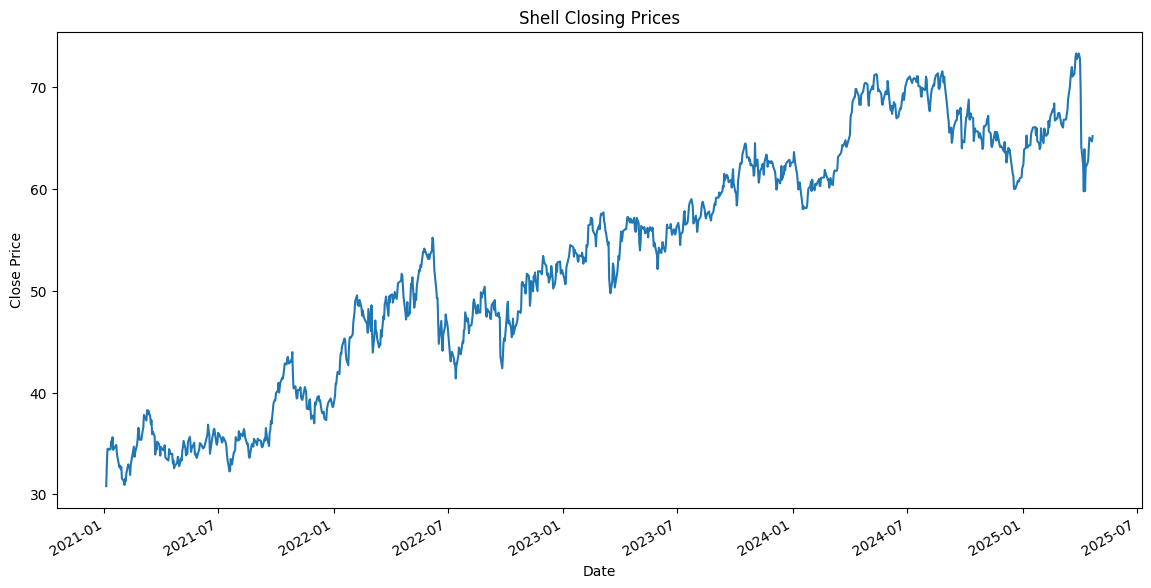

In [129]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_18556\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

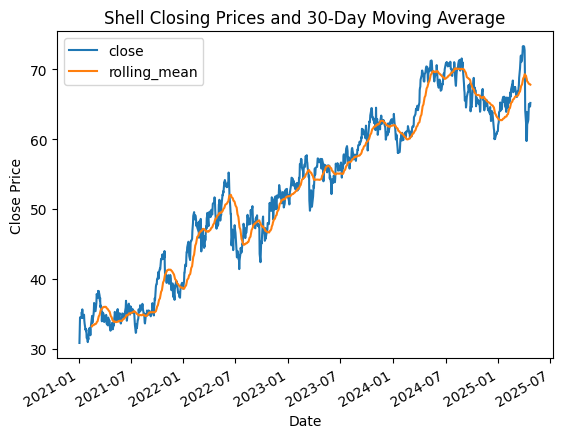

In [130]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [131]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

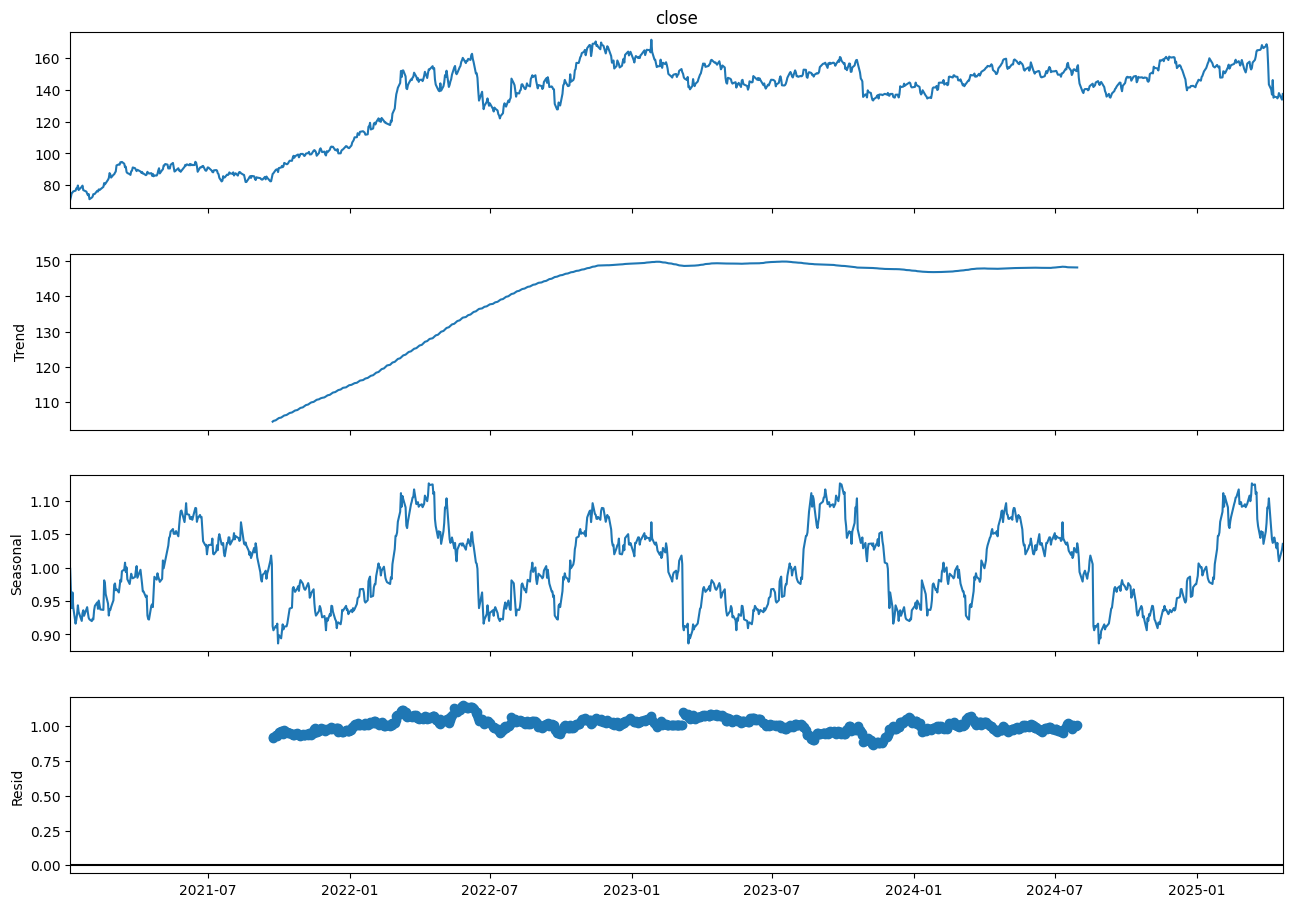

In [132]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

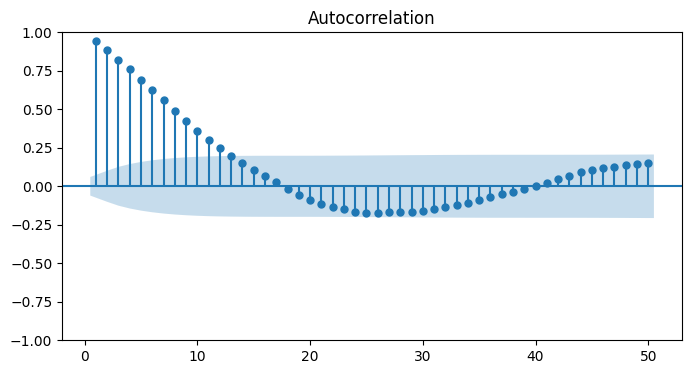

In [133]:
# Subtract long rolling average
detrend = cvx_stock['close'] - cvx_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

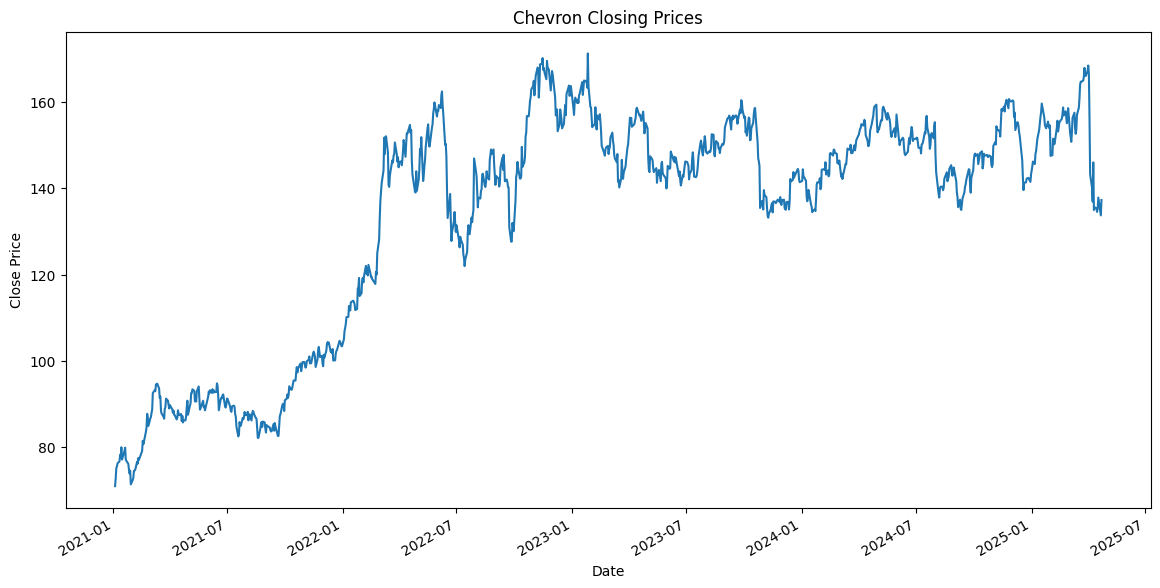

In [134]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_18556\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

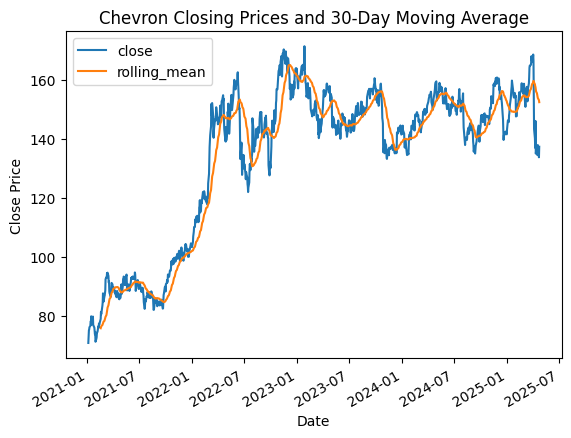

In [135]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# ADF Test & PACF Plot & ACF Plot

adf test_p-value when d = 0: 0.42971111123389755
adf test_p-value when d = 1: 0.0
Final d = 1


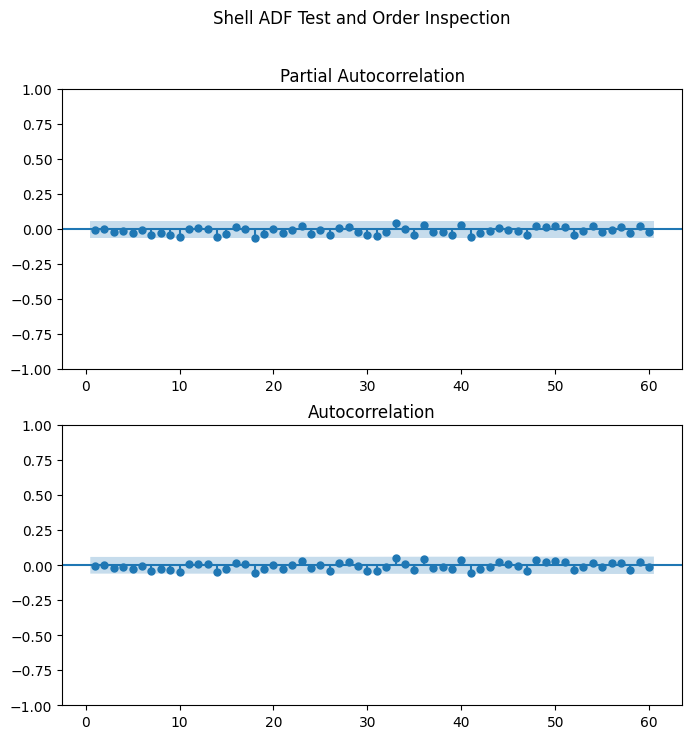

adf test_p-value when d = 0: 0.2674123457174855
adf test_p-value when d = 1: 0.0
Final d = 1


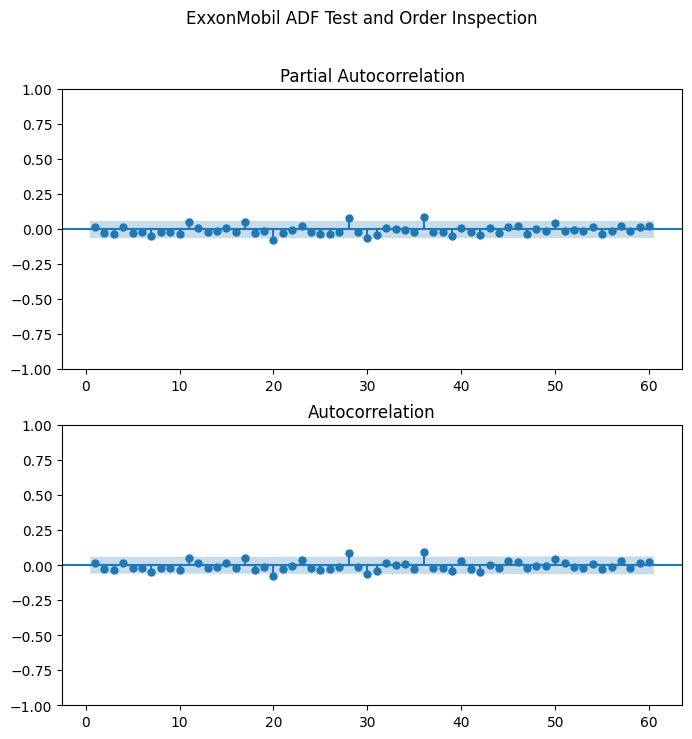

adf test_p-value when d = 0: 0.15400000150012494
adf test_p-value when d = 1: 0.0
Final d = 1


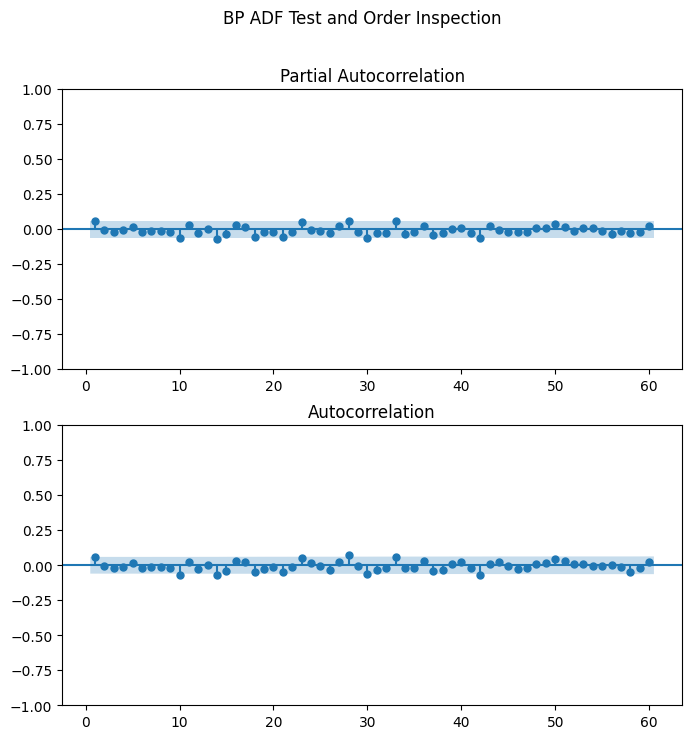

adf test_p-value when d = 0: 0.14896648090730058
adf test_p-value when d = 1: 0.0
Final d = 1


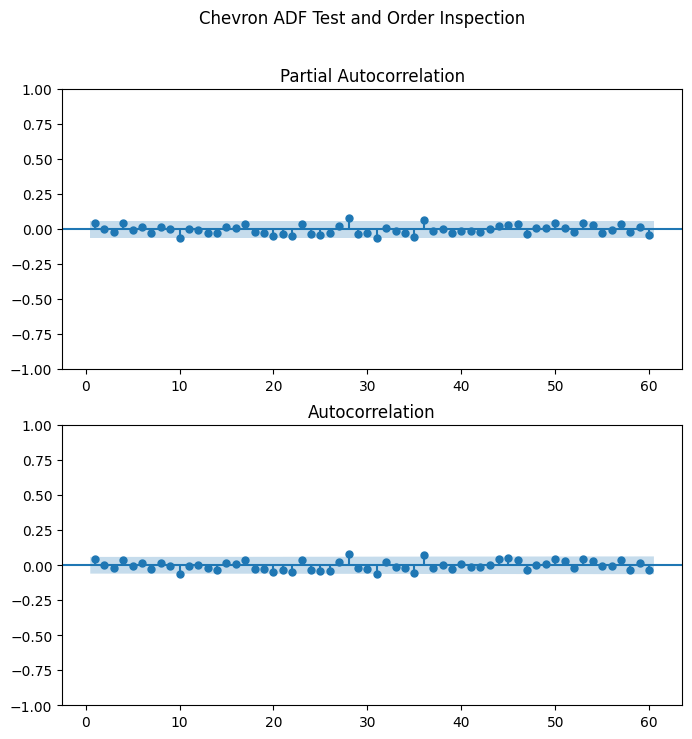

In [136]:
stock_data.set_index('date', inplace = True)

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker'] == ticker]['close']
    adf_result = adfuller(df)[1]
    d = 0
    print(f"adf test_p-value when d = {d}: {adf_result}")
    while adf_result >= 0.05 and d < 2:
        df = df.diff().dropna()
        d += 1
        adf_result = adfuller(df)[1]
        print(f"adf test_p-value when d = {d}: {adf_result}")
    print(f"Final d = {d}")
    fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))
    fig.suptitle(f"{tickers_names[ticker]} ADF Test and Order Inspection")
    ax1.set_title('PACF')
    ax2.set_title('ACF')
    plot_pacf(df, lags = 60, zero = False, ax = ax1)
    plot_acf(df, lags = 60, zero = False, ax = ax2)
    plt.show()
    

# Prediction

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1080
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1359.207
Date:                Wed, 23 Apr 2025   AIC                           2720.414
Time:                        21:40:42   BIC                           2725.398
Sample:                             0   HQIC                          2722.301
                               - 1080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7272      0.019     38.890      0.000       0.691       0.764
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               672.39
Prob(Q):                              0.93   Pr

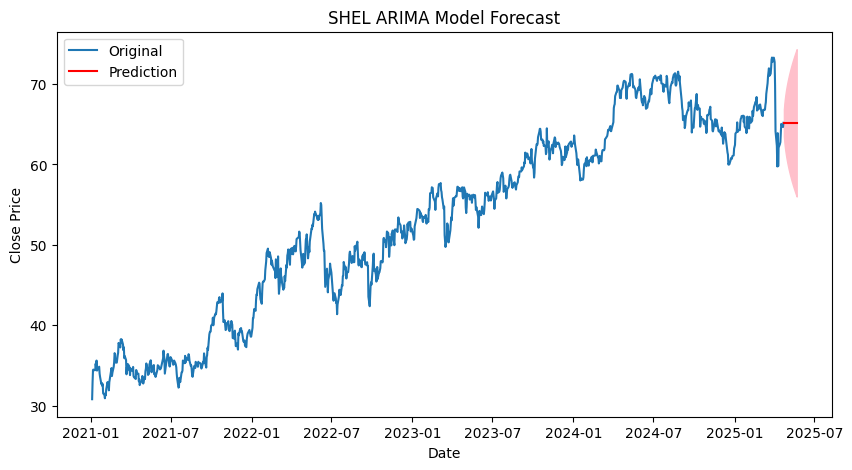

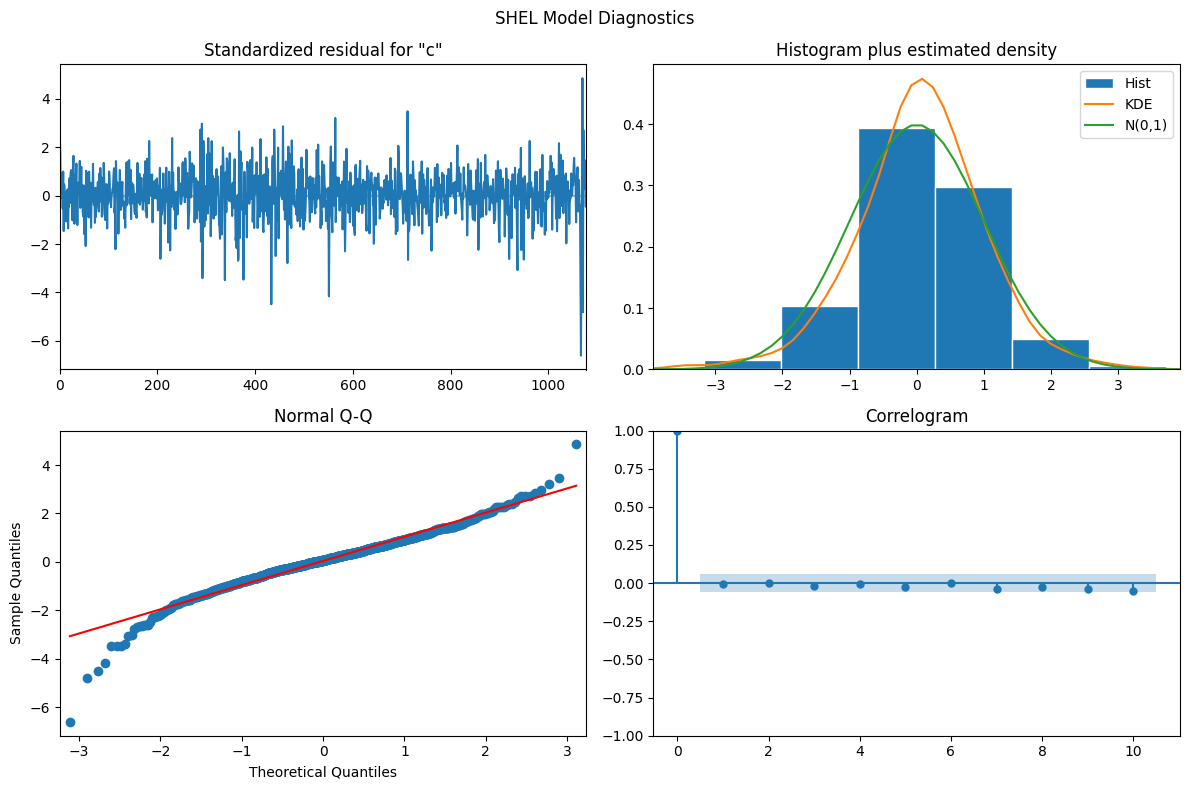

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1080
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1984.457
Date:                Wed, 23 Apr 2025   AIC                           3970.914
Time:                        21:40:43   BIC                           3975.898
Sample:                             0   HQIC                          3972.801
                               - 1080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3174      0.072     32.273      0.000       2.177       2.458
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               193.44
Prob(Q):                              0.54   Pr

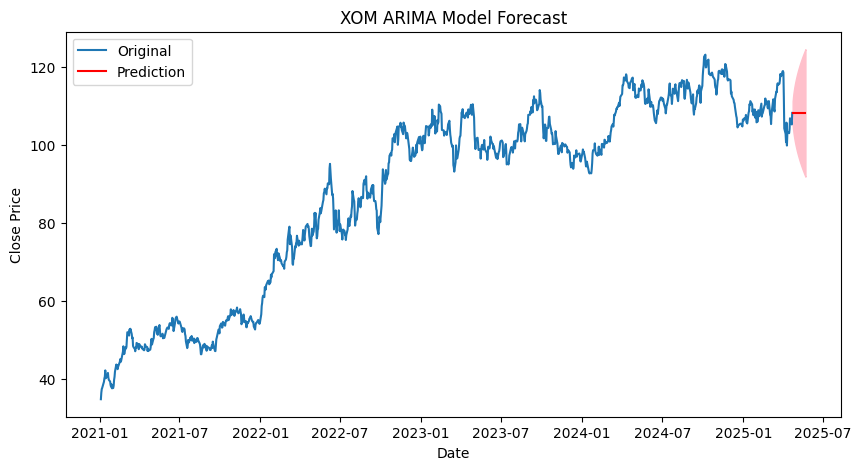

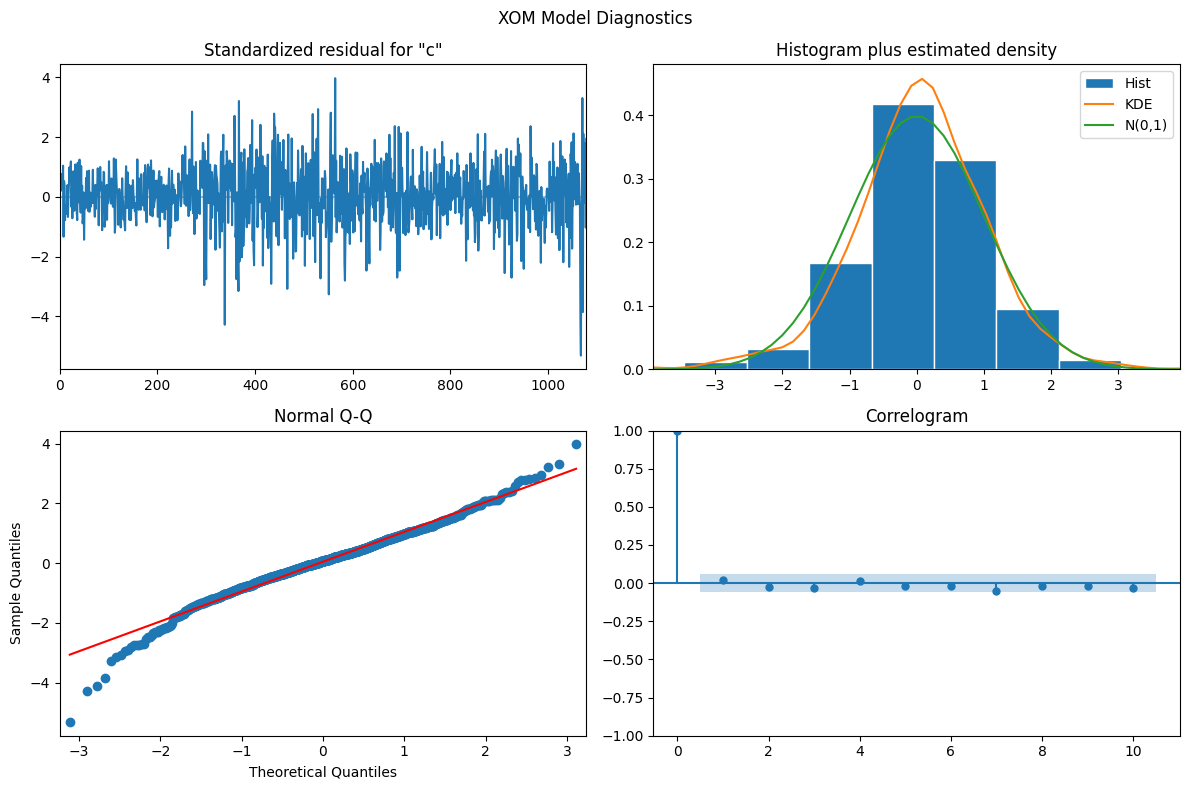

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1080
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -831.360
Date:                Wed, 23 Apr 2025   AIC                           1664.719
Time:                        21:40:44   BIC                           1669.703
Sample:                             0   HQIC                          1666.606
                               - 1080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2734      0.007     40.263      0.000       0.260       0.287
Ljung-Box (L1) (Q):                   3.75   Jarque-Bera (JB):               782.83
Prob(Q):                              0.05   Pr

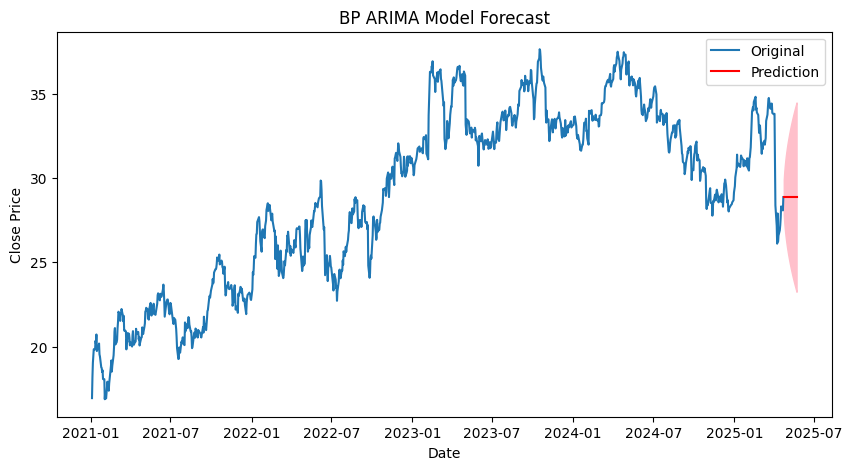

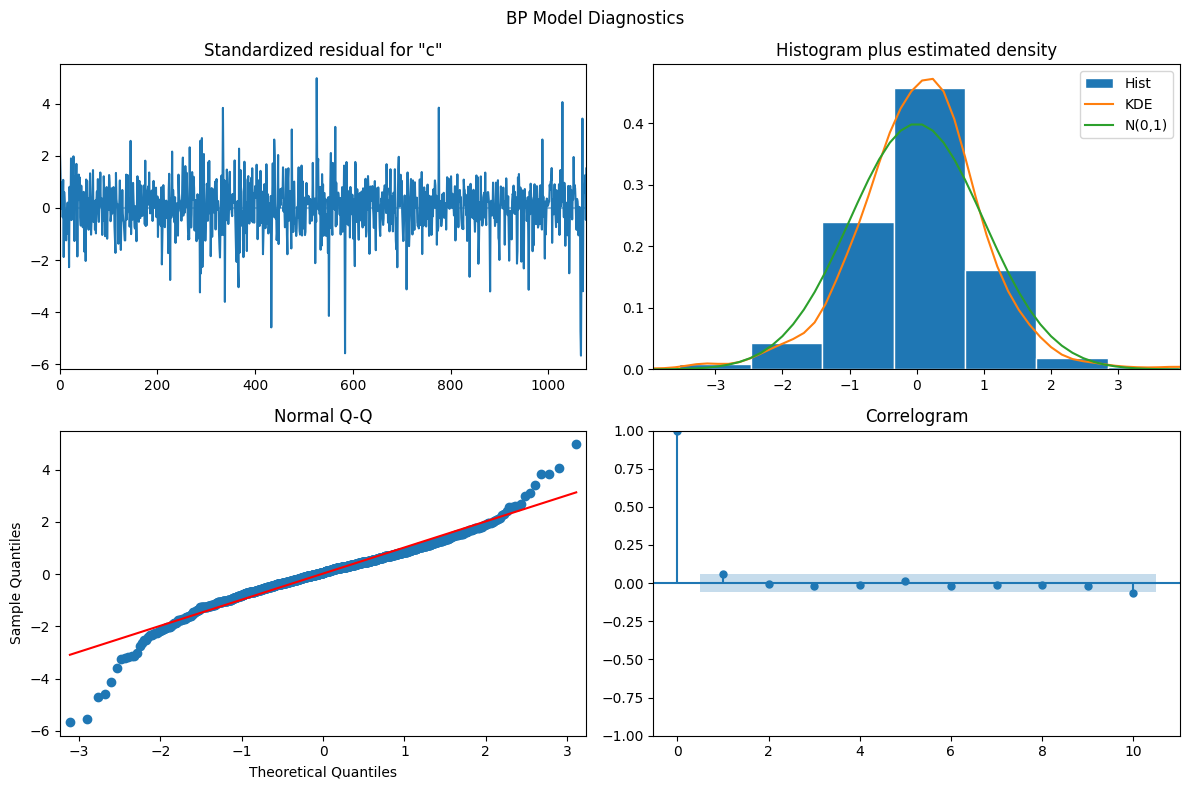

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1080
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2407.400
Date:                Wed, 23 Apr 2025   AIC                           4816.800
Time:                        21:40:45   BIC                           4821.784
Sample:                             0   HQIC                          4818.687
                               - 1080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.0754      0.126     40.174      0.000       4.828       5.323
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):               804.92
Prob(Q):                              0.14   Pr

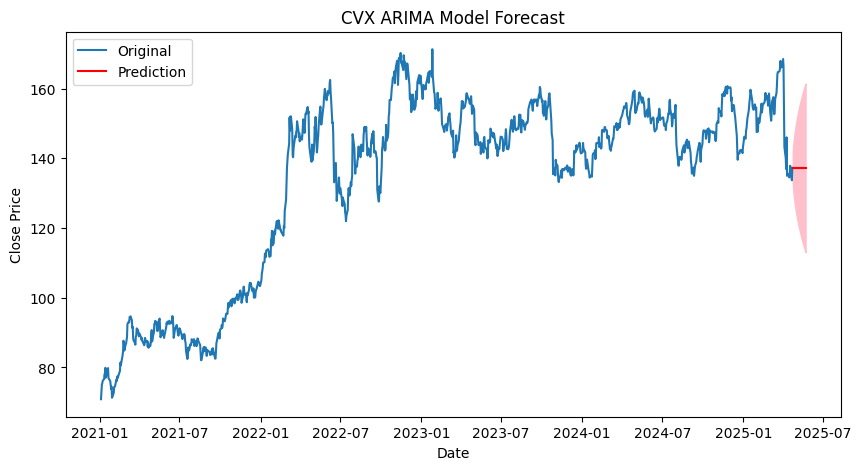

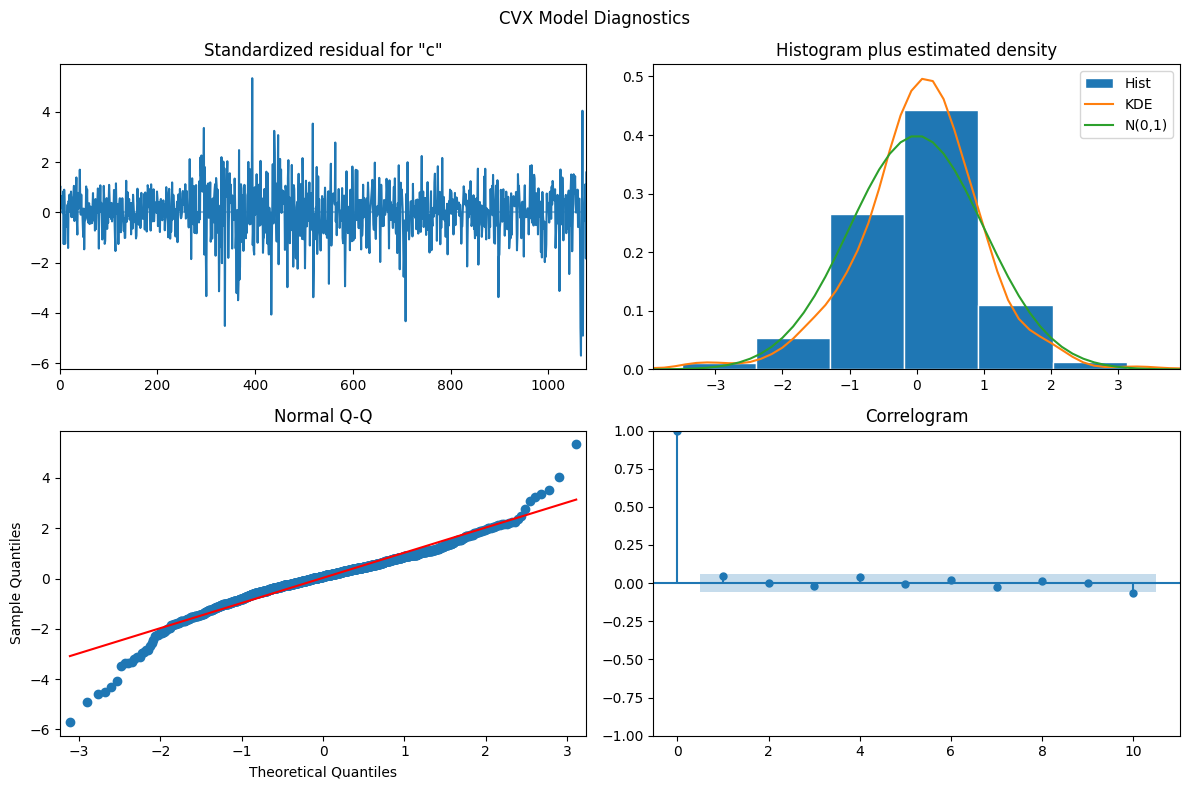

In [137]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker']==ticker]['close']

    model = ARIMA(df, order = (0,1,0))
    results = model.fit()
    print(results.summary())

    predict = results.get_forecast(steps = 30)
    last_date = stock_data[stock_data['ticker'] == ticker].index.max()
    predict_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    # predict_index = pd.date_range(start = df[-1], periods = 30, freq = 'D')
    predict_mean = predict.predicted_mean
    predict_conf_int = predict.conf_int()

    plt.figure(figsize = (10,5))
    plt.plot(df, label = 'Original')
    plt.plot(predict_index, predict_mean, color = 'red', label = 'Prediction')
    plt.fill_between(predict_index, predict_conf_int.iloc[:,0], predict_conf_int.iloc[:,1], color = 'pink')
    plt.title(f"{ticker} ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel('Close Price')
    plt.legend()
    plt.savefig(f"plots/predictions/{ticker}_ARIMA_model_forecast.png", dpi=300, bbox_inches='tight') 
    plt.show()

    diag_fig = results.plot_diagnostics(figsize = (12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()






## Prediction with Train Test Split

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1050.724
Date:                Wed, 23 Apr 2025   AIC                           2103.448
Time:                        21:40:47   BIC                           2108.209
Sample:                             0   HQIC                          2105.271
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6684      0.024     27.818      0.000       0.621       0.716
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               108.54
Prob(Q):                  

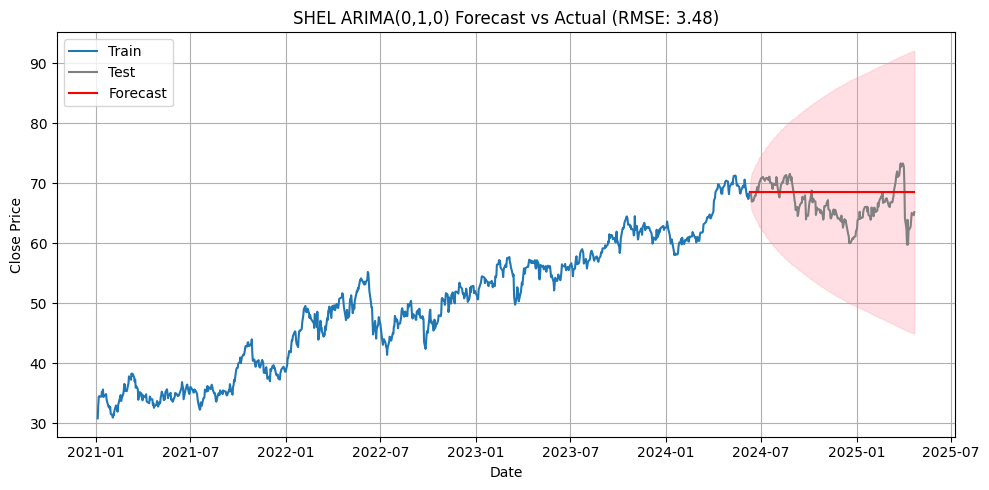

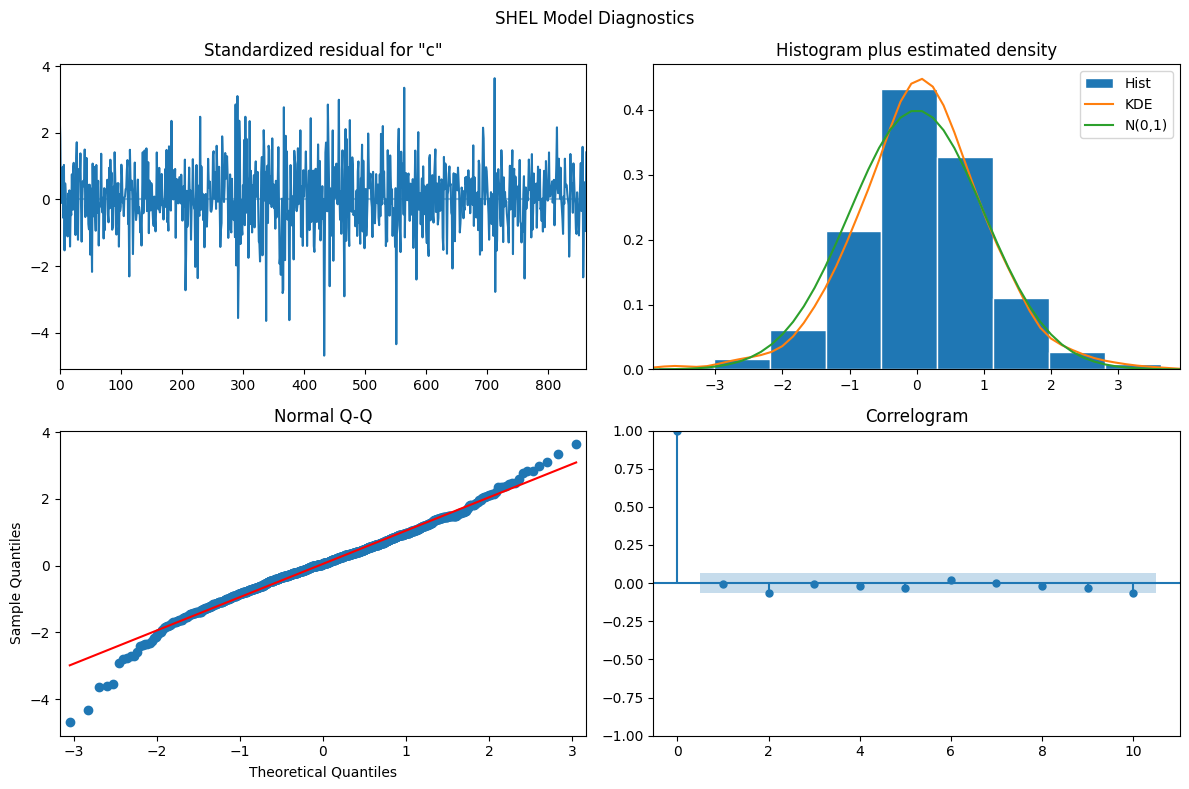

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1557.906
Date:                Wed, 23 Apr 2025   AIC                           3117.812
Time:                        21:40:48   BIC                           3122.572
Sample:                             0   HQIC                          3119.634
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1653      0.081     26.725      0.000       2.007       2.324
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                71.96
Prob(Q):                   

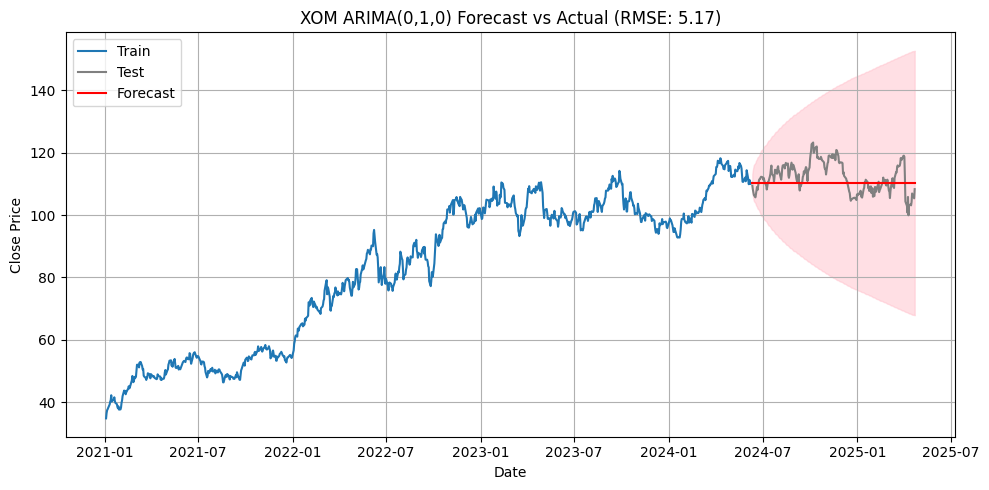

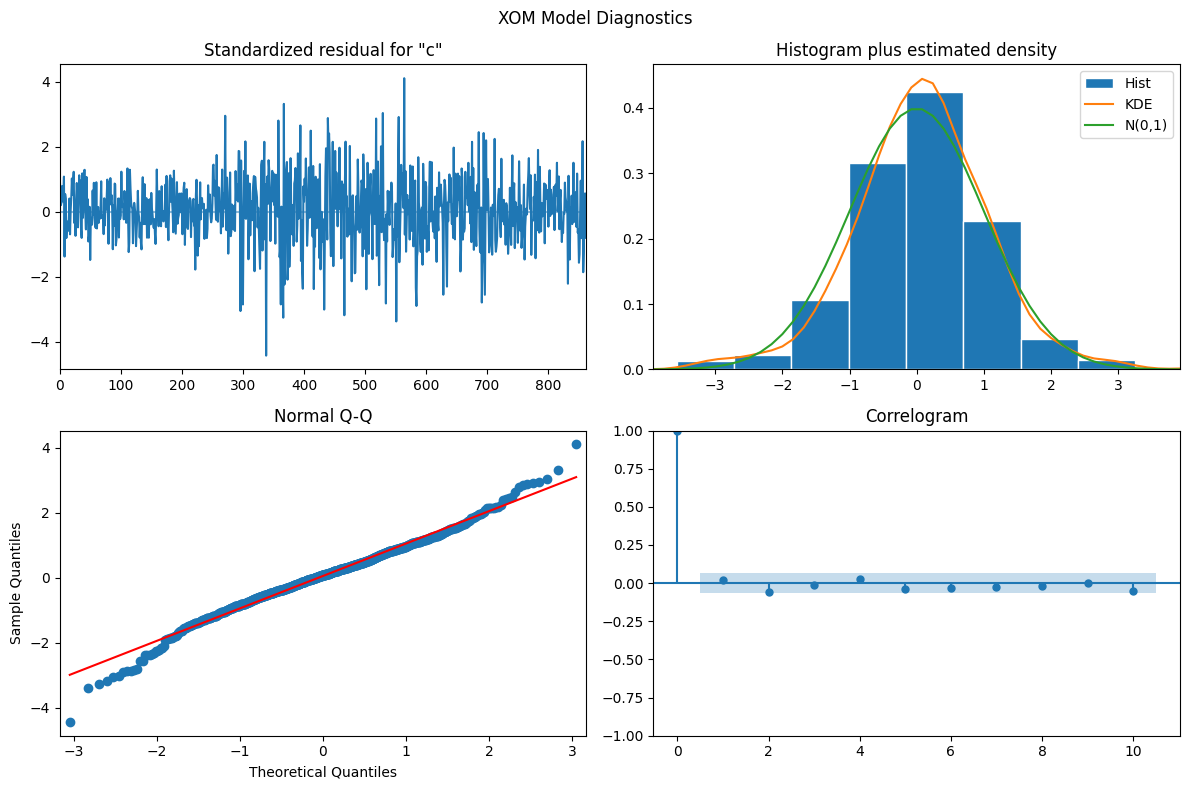

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -647.411
Date:                Wed, 23 Apr 2025   AIC                           1296.822
Time:                        21:40:49   BIC                           1301.583
Sample:                             0   HQIC                          1298.644
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2625      0.008     33.628      0.000       0.247       0.278
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               400.83
Prob(Q):                    

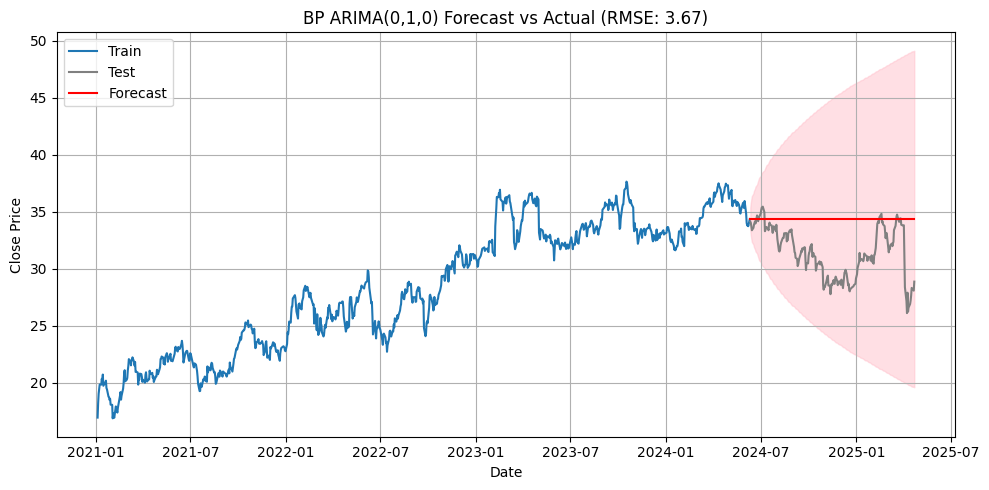

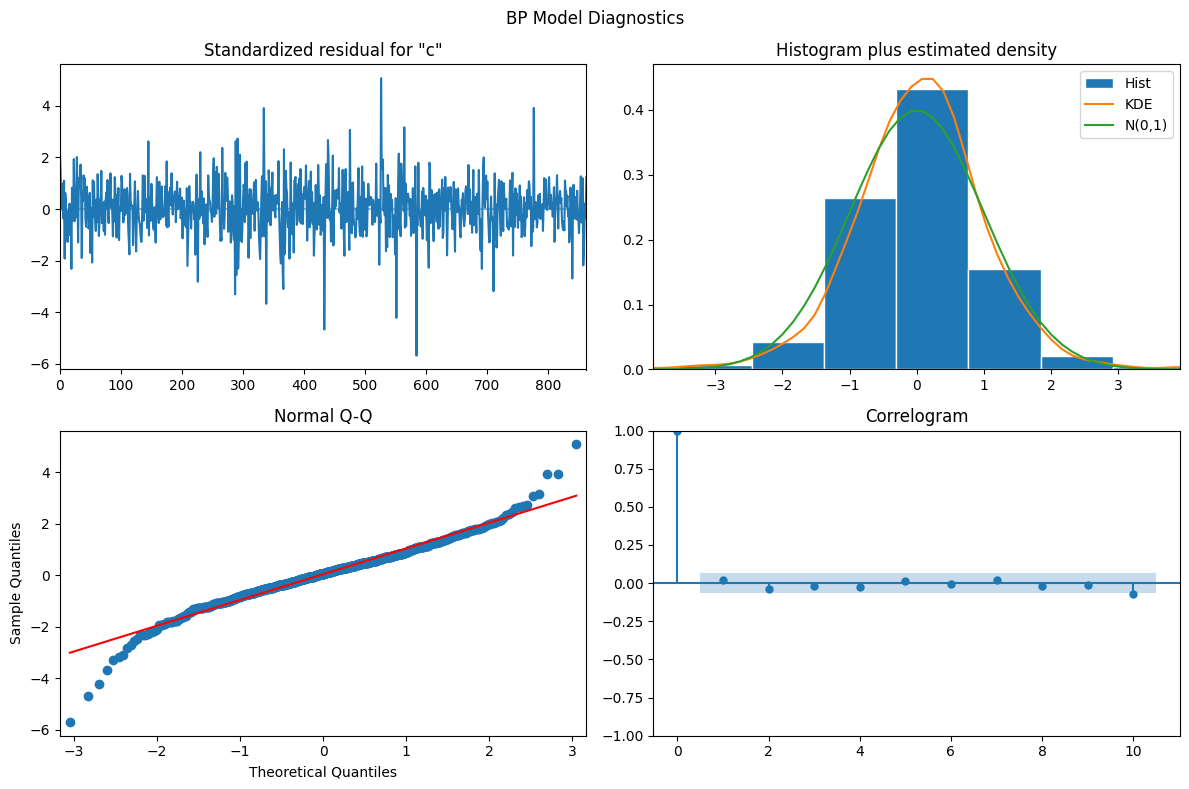

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1904.428
Date:                Wed, 23 Apr 2025   AIC                           3810.857
Time:                        21:40:50   BIC                           3815.617
Sample:                             0   HQIC                          3812.679
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.8338      0.147     32.777      0.000       4.545       5.123
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               346.27
Prob(Q):                   

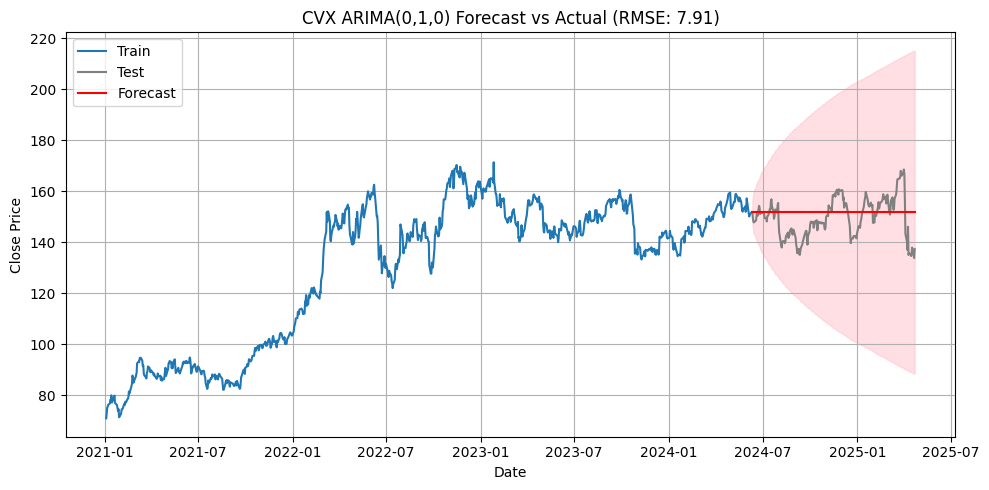

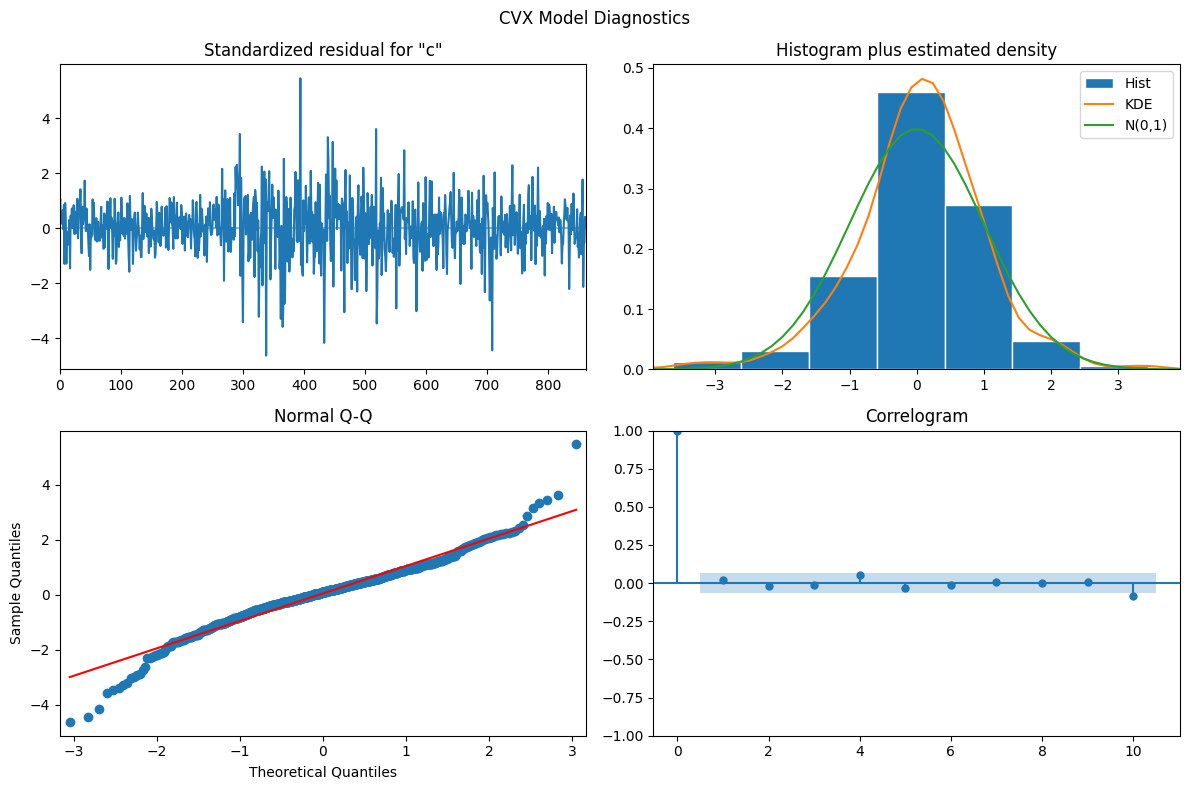

In [ ]:
rmse_dict = {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    model = ARIMA(train, order=(0, 1, 0))
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_forecast_vs_actual.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

## Prediction with Crude Oil Price Data

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -908.428
Date:                Wed, 23 Apr 2025   AIC                           1820.855
Time:                        21:40:51   BIC                           1830.376
Sample:                             0   HQIC                          1824.500
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2089      0.007     28.124      0.000       0.194       0.224
sigma2         0.4807      0.016     29.808      0.000       0.449       0.512
Ljung-Box (L1) (Q):            

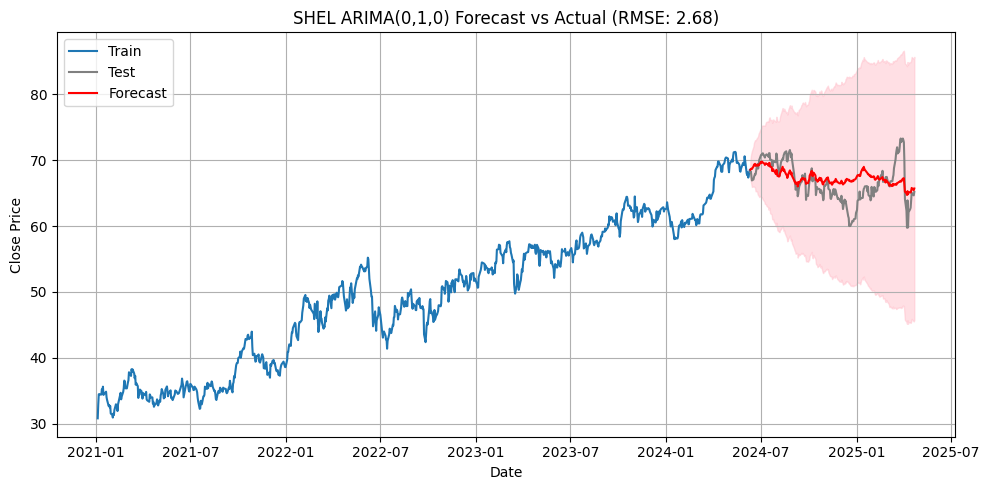

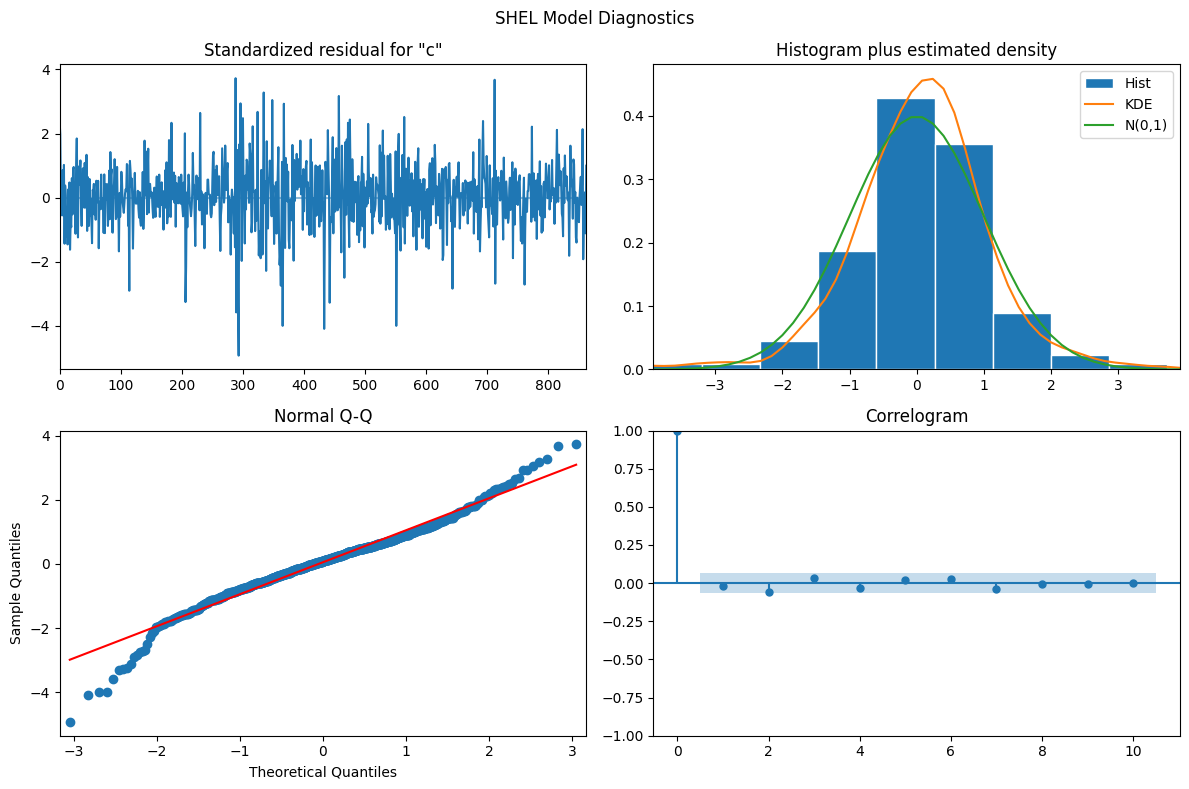

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1366.894
Date:                Wed, 23 Apr 2025   AIC                           2737.787
Time:                        21:40:52   BIC                           2747.308
Sample:                             0   HQIC                          2741.432
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4244      0.015     28.442      0.000       0.395       0.454
sigma2         1.3908      0.052     26.566      0.000       1.288       1.493
Ljung-Box (L1) (Q):             

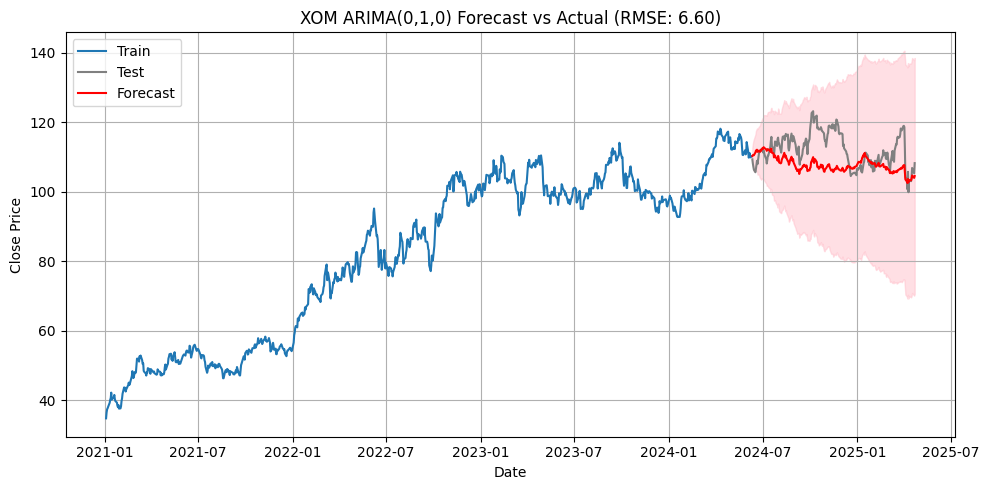

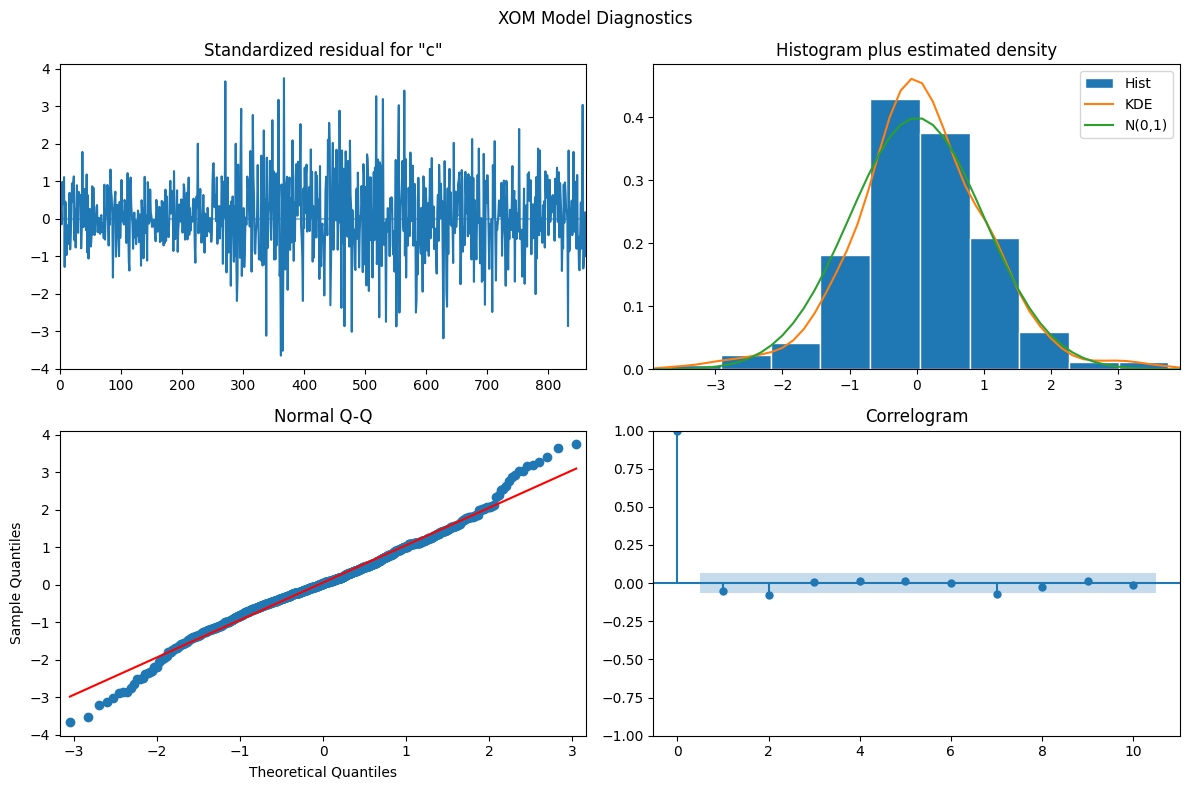

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -507.983
Date:                Wed, 23 Apr 2025   AIC                           1019.966
Time:                        21:40:53   BIC                           1029.487
Sample:                             0   HQIC                          1023.611
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.1298      0.005     28.173      0.000       0.121       0.139
sigma2         0.1900      0.005     37.674      0.000       0.180       0.200
Ljung-Box (L1) (Q):              

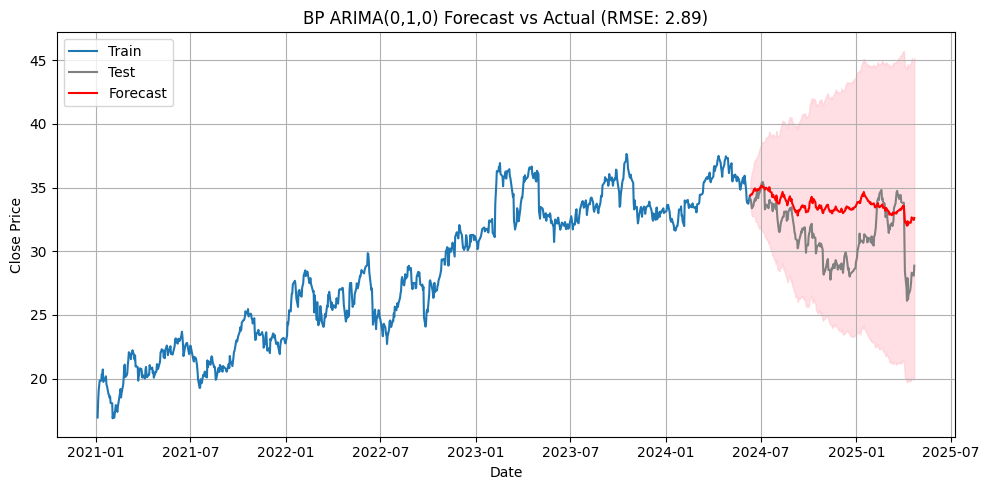

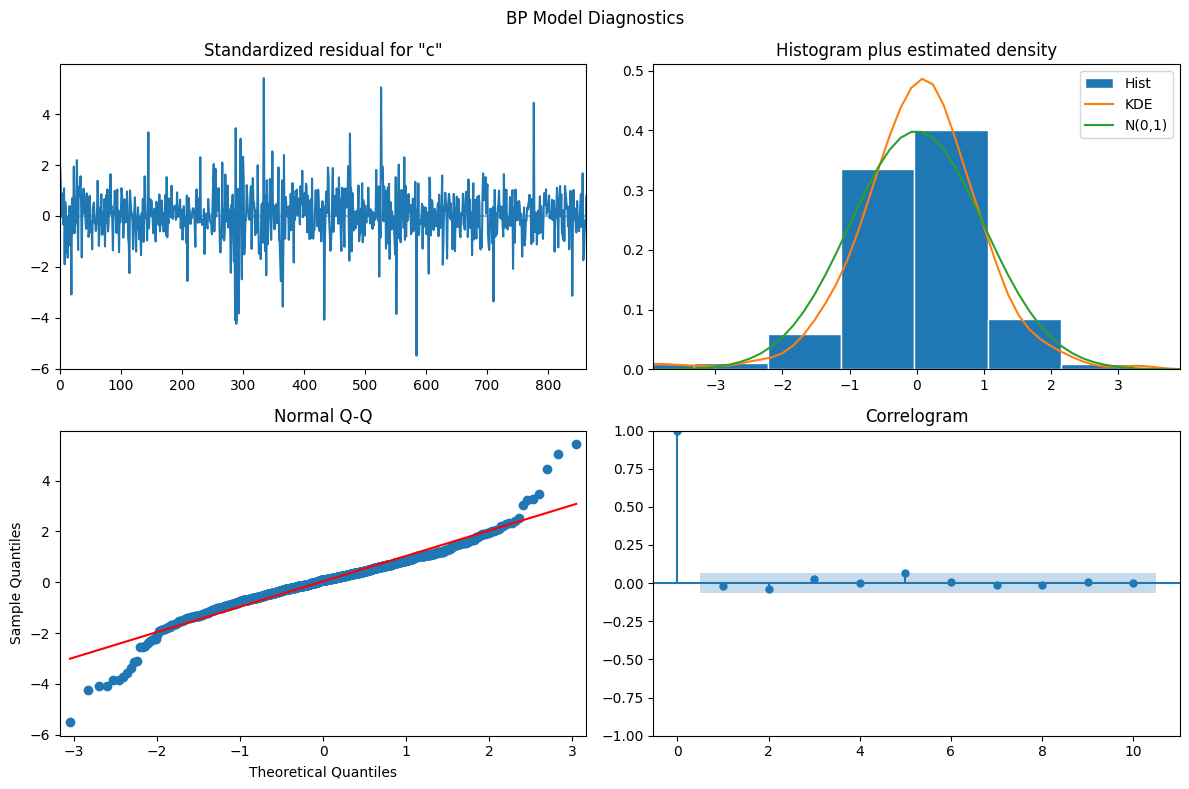

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1750.748
Date:                Wed, 23 Apr 2025   AIC                           3505.496
Time:                        21:40:55   BIC                           3515.017
Sample:                             0   HQIC                          3509.140
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.5803      0.022     26.491      0.000       0.537       0.623
sigma2         3.3855      0.089     37.849      0.000       3.210       3.561
Ljung-Box (L1) (Q):             

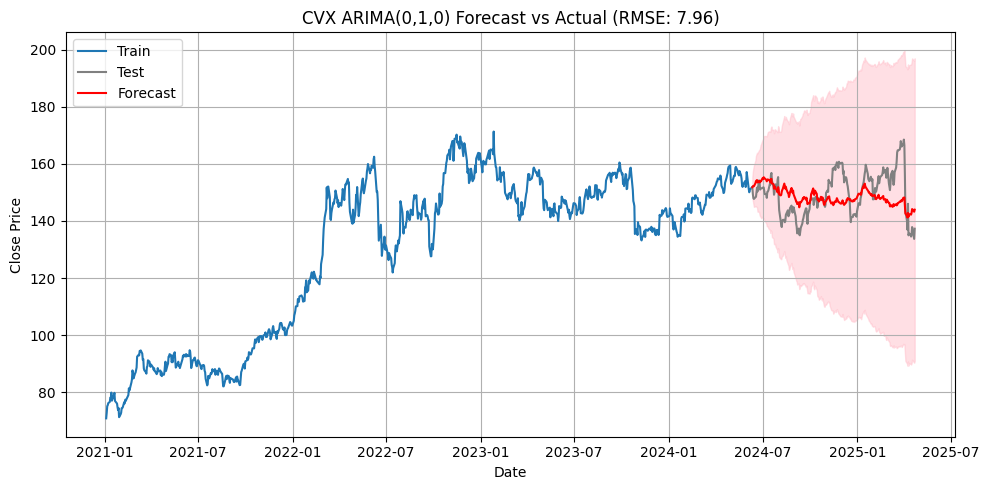

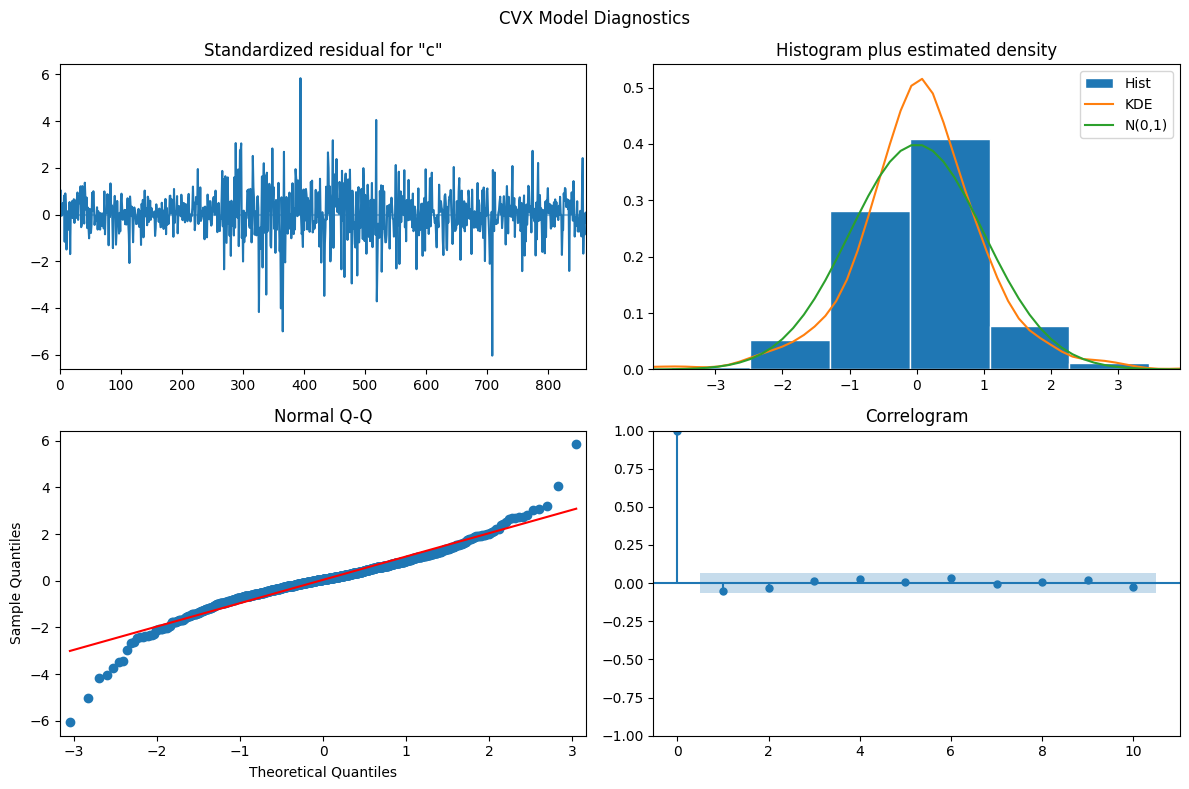

In [ ]:
rmse_oil_dict =  {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='CL=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_oil_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_with_crude_oil_price.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_with_oil_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

In [140]:
print(rmse_dict)
print(rmse_oil_dict)

{'SHEL': np.float64(3.4787367740607062), 'XOM': np.float64(5.166974174336191), 'BP': np.float64(3.6717734034481606), 'CVX': np.float64(7.914846139186488)}
{'SHEL': np.float64(2.6779417521138003), 'XOM': np.float64(6.601937113459229), 'BP': np.float64(2.891562764877961), 'CVX': np.float64(7.957776012697674)}


## Prediction with Natural Gas Data


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1042.431
Date:                Wed, 23 Apr 2025   AIC                           2088.862
Time:                        21:40:56   BIC                           2098.382
Sample:                             0   HQIC                          2092.506
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4676      0.107      4.365      0.000       0.258       0.678
sigma2         0.6557      0.024     27.309      0.000       0.609       0.703
Ljung-Box (L1) (Q):            

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

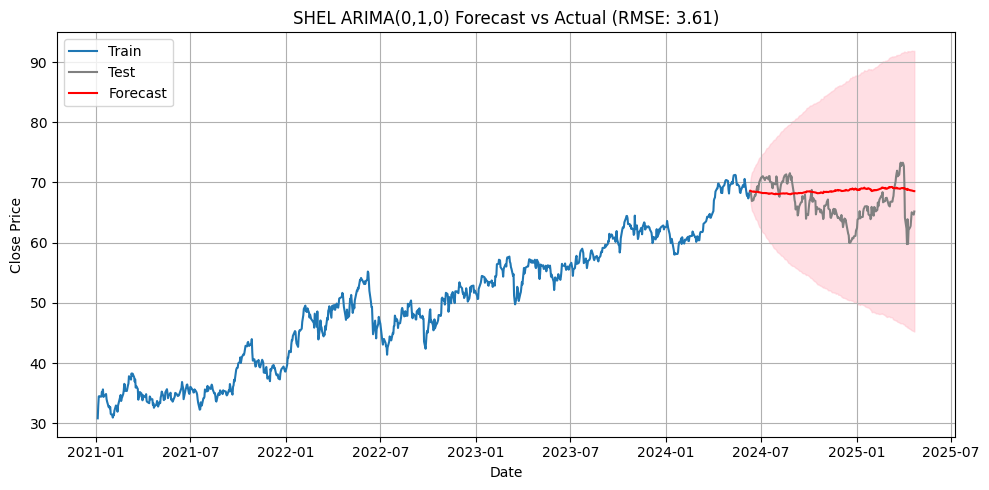

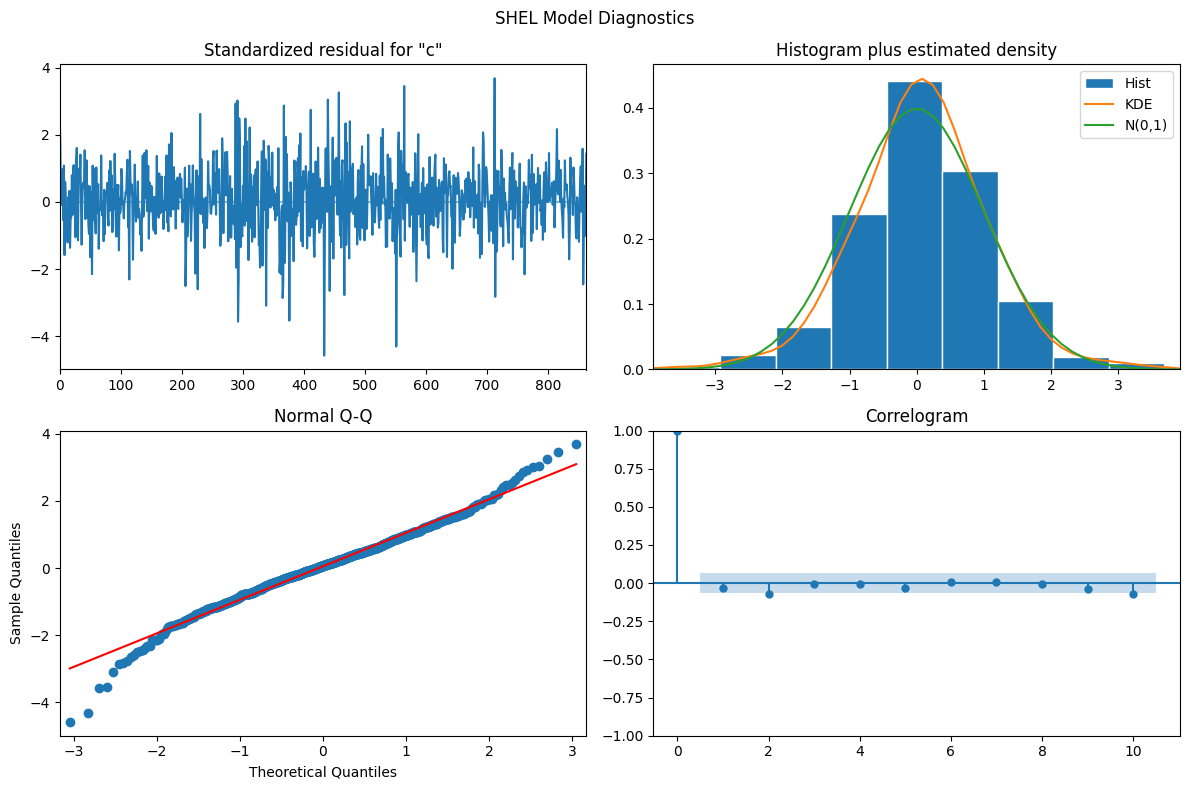

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1545.314
Date:                Wed, 23 Apr 2025   AIC                           3094.628
Time:                        21:40:57   BIC                           3104.149
Sample:                             0   HQIC                          3098.272
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.0344      0.177      5.854      0.000       0.688       1.381
sigma2         2.1031      0.081     25.993      0.000       1.944       2.262
Ljung-Box (L1) (Q):             

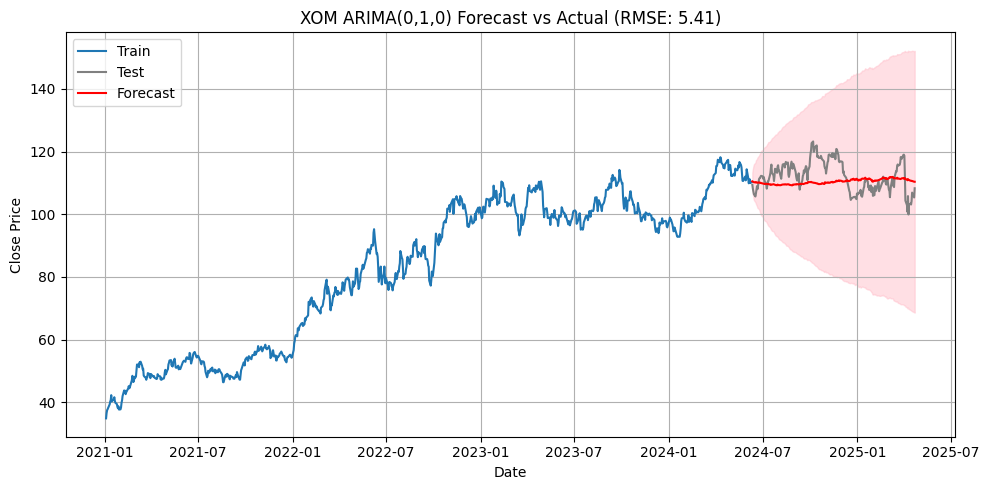

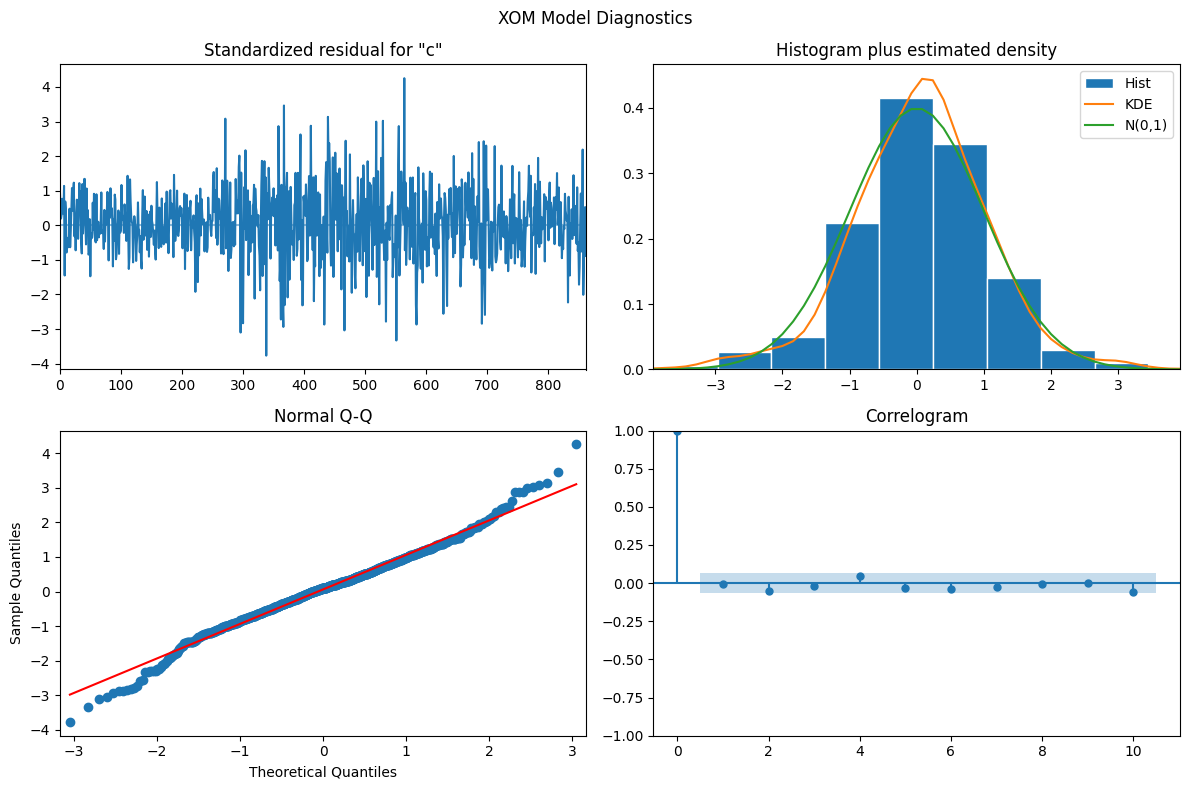

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -639.454
Date:                Wed, 23 Apr 2025   AIC                           1282.908
Time:                        21:40:58   BIC                           1292.429
Sample:                             0   HQIC                          1286.553
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2871      0.072      3.987      0.000       0.146       0.428
sigma2         0.2577      0.008     32.684      0.000       0.242       0.273
Ljung-Box (L1) (Q):              

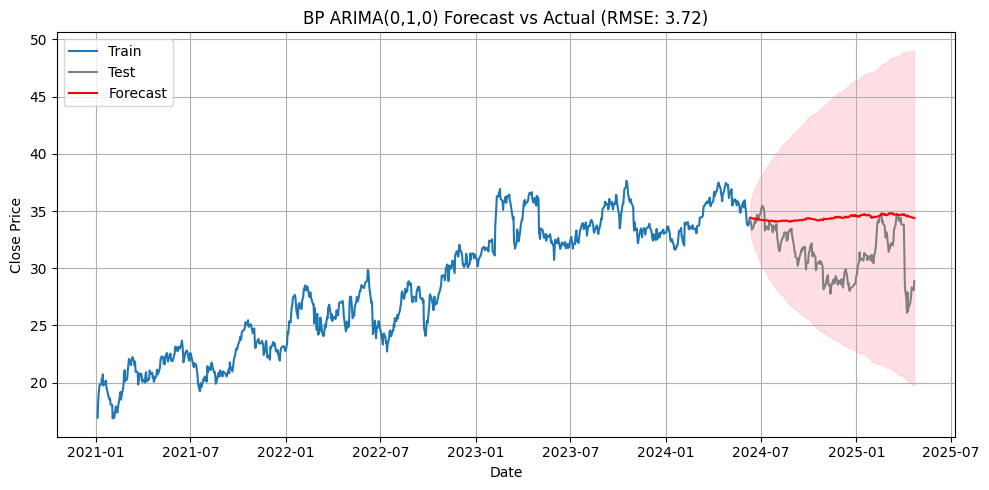

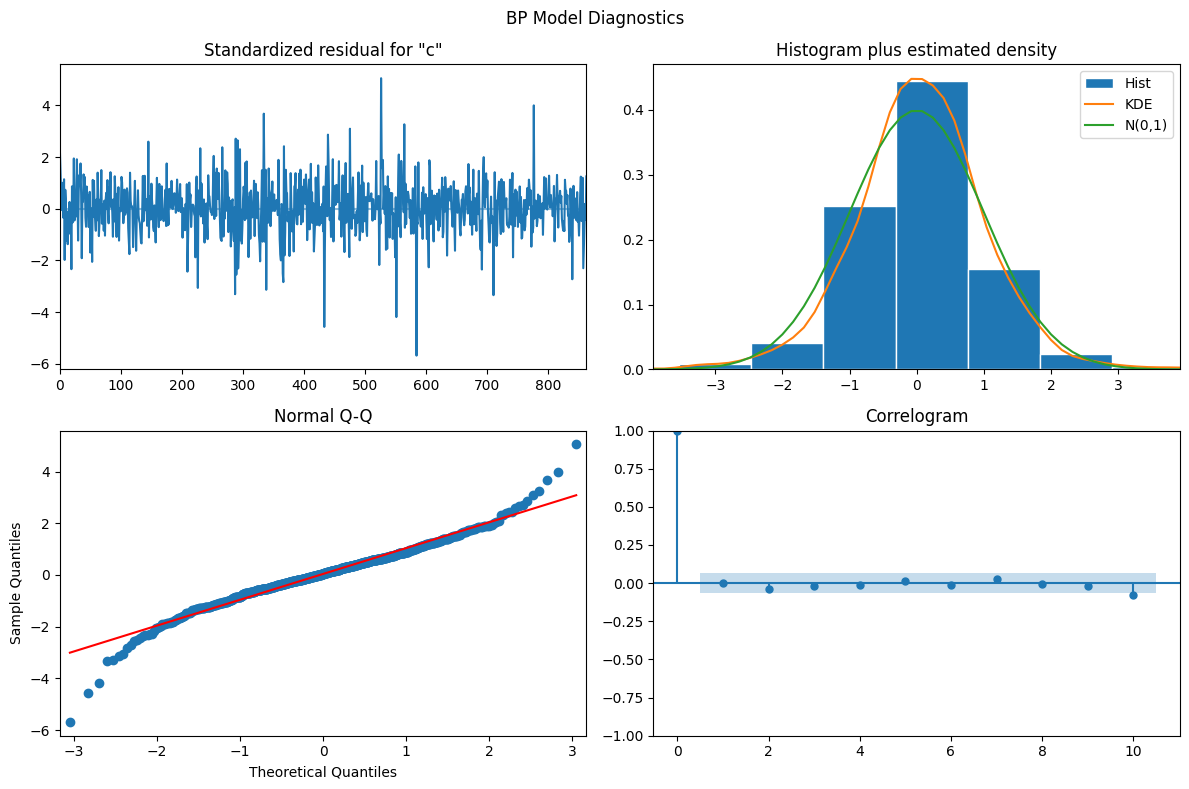

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1890.733
Date:                Wed, 23 Apr 2025   AIC                           3785.466
Time:                        21:41:00   BIC                           3794.987
Sample:                             0   HQIC                          3789.110
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.6109      0.264      6.093      0.000       1.093       2.129
sigma2         4.6828      0.144     32.483      0.000       4.400       4.965
Ljung-Box (L1) (Q):             

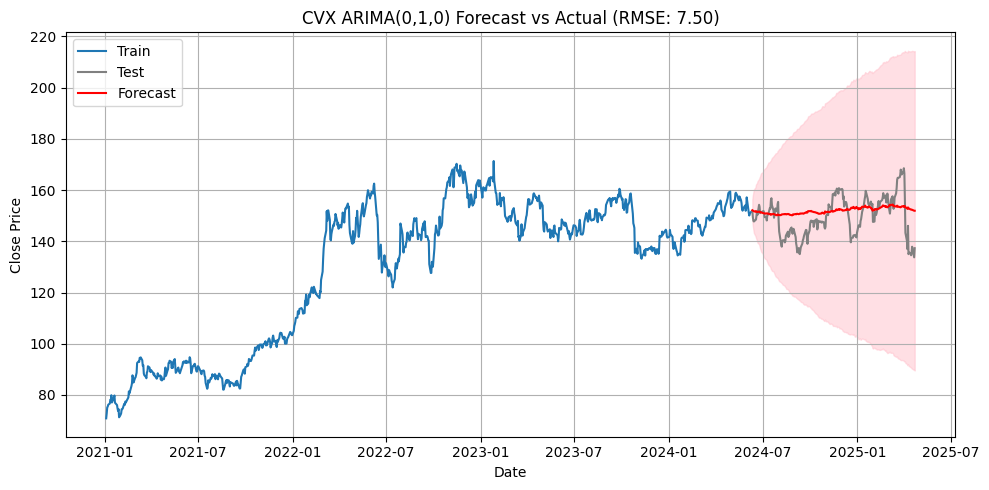

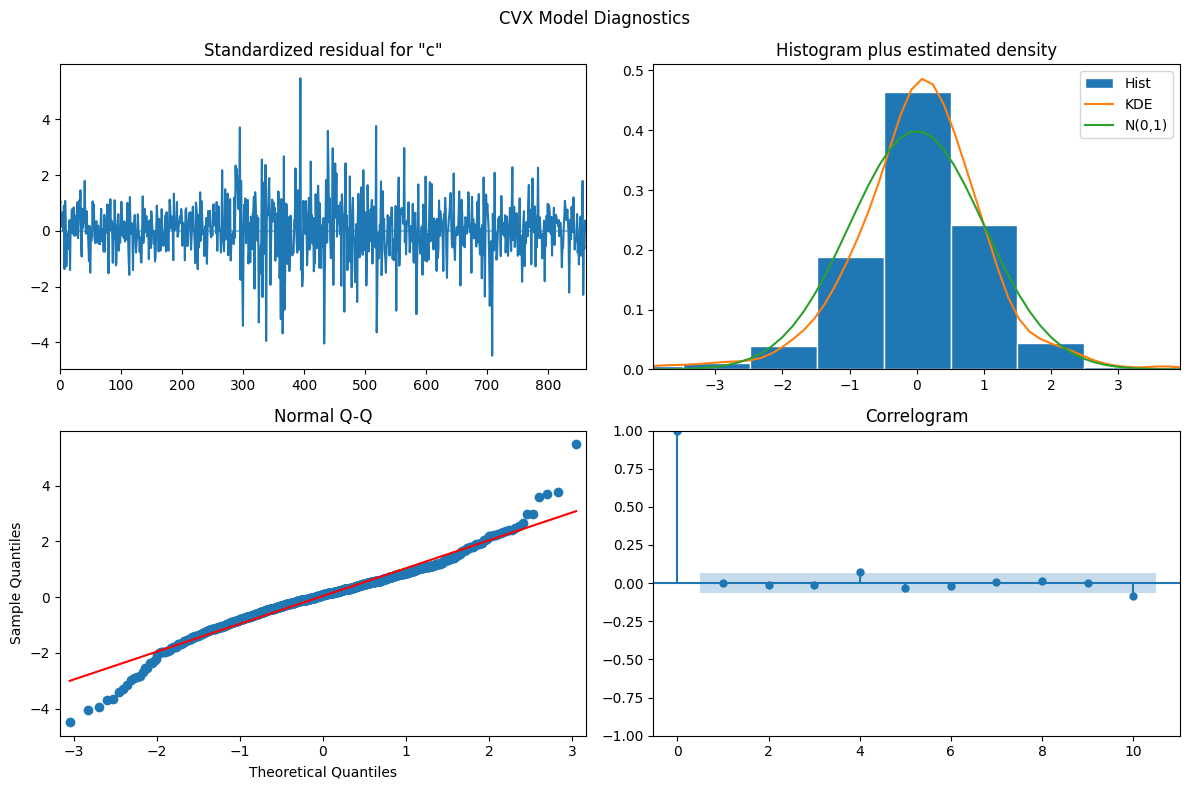

In [ ]:
rmse_gas_dict = {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='NG=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_gas_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_with_natural_gas_price.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_with_gas_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

## Model Comparison

In [ ]:
rmse_comparison_df = pd.DataFrame({
    'ARIMA': rmse_dict,
    'ARIMA + Crude Oil': rmse_oil_dict,
    'ARIMA + Natural Gas': rmse_gas_dict
})

rmse_comparison_df = rmse_comparison_df.round(3)
print(rmse_comparison_df)

      ARIMA  ARIMA + Crude Oil  ARIMA + Natural Gas
SHEL  3.479              2.678                3.609
XOM   5.167              6.602                5.413
BP    3.672              2.892                3.721
CVX   7.915              7.958                7.501
